# 1. Introduction théorique : VAE vs CVAE

L'objectif de ce mini-projet est de définir et d'entraîner un **Auto-encodeur Variationnel Conditionnel (CVAE)** sur le jeu de données **Fashion-MNIST**.

---

## 1.1 VAE (Variational Autoencoder) : Apprendre la structure des données

Un **Variational Autoencoder (VAE)** est un modèle génératif latent qui suppose que chaque observation $x$ (par exemple une image) est générée à partir d'une variable cachée continue $z \in \mathbb{R}^d$.

### Les composants du VAE

- **L’espace latent ($z$)**  
  On définit un *prior* simple sur la variable latente :
  $$
  p(z) = \mathcal{N}(0, I).
  $$

- **L’encodeur ($q_\phi(z \mid x)$)**  
  Il approxime la distribution a posteriori du latent :
  $$
  q_\phi(z \mid x) = \mathcal{N}\left(\mu_\phi(x), \mathrm{diag}(\sigma_\phi(x)^2)\right).
  $$

- **Le décodeur ($p_\theta(x \mid z)$)**  
  Il modélise le processus génératif permettant de reconstruire l’image :
  $$
  p_\theta(x \mid z).
  $$

---

### Le *Reparameterization Trick*

Pour permettre la rétropropagation du gradient à travers l’échantillonnage :
$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon,
\quad \epsilon \sim \mathcal{N}(0, I).
$$

---

### Pourquoi utiliser une $\beta$-ELBO comme fonction de perte ?

L’objectif théorique d’un modèle génératif est de maximiser la vraisemblance des données :

$$
\log p_\theta(x) = \log \int p_\theta(x \mid z)\, p(z)\, dz,
$$

mais cette intégrale est intractable.  
On introduit donc une approximation variationnelle $q_\phi(z\mid x)$ et on maximise une borne inférieure appelée **ELBO** :

$$
\mathcal{L}(x)=
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
-
\mathrm{KL}\big(q_\phi(z \mid x)\ \|\ p(z)\big).
$$

En pratique, on ne maximise pas l’ELBO mais on **minimise sa négative**, ce qui conduit à une fonction de perte composée de deux termes :

- un **terme de reconstruction**, correspondant à la négative log-vraisemblance (implémenté ici par une BCE sur les logits) ;
- un **terme de régularisation (KL)**, qui contraint la distribution latente à rester proche du prior gaussien.

Dans nos expériences, cette perte prend la forme :

$$
\mathcal{J}_\beta(x)
=
\mathrm{BCE}(x,\text{logits})
+
\beta\,\mathrm{KL}\big(q_\phi(z\mid x)\|p(z)\big),
$$

ce qui correspond à une formulation de type **$\beta$-VAE**.

Le coefficient $\beta$ permet de contrôler le compromis entre :

- la fidélité de reconstruction des images,
- l’utilisation effective et la structuration de l’espace latent.

Ce réglage est particulièrement important dans notre étude, car plusieurs métriques (KL, Active Units, FMD, cohérence conditionnelle) dépendent directement de la capacité du modèle à exploiter réellement le latent.


## 1.2 CVAE (Conditional VAE) : Introduire le contrôle

Le **CVAE** étend le VAE en conditionnant le modèle par une variable supplémentaire $y$ (ici, la classe du vêtement).

### Modifications du modèle

- **Encodeur conditionnel**
  $$
  q_\phi(z \mid x, y),
  $$

- **Décodeur conditionnel**
  $$
  p_\theta(x \mid z, y).
  $$

Le modèle apprend alors la distribution conditionnelle :
$$
x \sim p_\theta(x \mid y).
$$

---
### $\beta$-ELBO conditionnelle

Dans le cadre conditionnel, on cherche à modéliser la vraisemblance $\log p_\theta(x \mid y)$, qui reste intractable à cause de l’intégration sur le latent.  
On introduit donc l’approximation variationnelle $q_\phi(z \mid x, y)$ et on obtient la borne :

$$
\mathcal{L}(x,y)=
\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]
-
\mathrm{KL}\big(q_\phi(z \mid x, y)\ \|\ p(z)\big).
$$

En pratique, on minimise sa négative sous la forme pondérée :

$$
\mathcal{J}_\beta(x,y)=
\mathrm{BCE}(x,\text{logits})
+
\beta\,\mathrm{KL}\big(q_\phi(z\mid x,y)\|p(z)\big).
$$

## Différence d’usage entre VAE et CVAE

Au-delà des équations proches, **leur usage est différent**.

### Usage du VAE

Le VAE apprend la distribution globale $p(x)$ sans information externe.  
Il est utilisé pour :

- apprendre une représentation latente compacte,
- reconstruire des observations,
- générer des données plausibles mais **non contrôlées**,
- analyser la structure intrinsèque du jeu de données.

Lors de la génération :
$$
z \sim \mathcal{N}(0, I), \quad x \sim p_\theta(x \mid z),
$$
la classe ou le contenu de l’image générée ne peut pas être imposé.

---

### Usage du CVAE

Le CVAE apprend la distribution conditionnelle $p(x \mid y)$.  
Il est utilisé lorsque l’on souhaite **contrôler la génération** :

- générer des données appartenant à une classe précise,
- produire plusieurs variantes d’un même type d’objet,
- structurer l’espace latent en fonction d’une information externe.

Lors de la génération :
$$
z \sim \mathcal{N}(0, I), \quad x \sim p_\theta(x \mid z, y),
$$
la variable $y$ permet de choisir explicitement le type d’image générée.

---

## Références scientifiques

- Kingma, D. P., & Welling, M. (2014).  
  *Auto-Encoding Variational Bayes*. ICLR.

- Sohn, K., Lee, H., & Yan, X. (2015).  
  *Learning Structured Output Representation using Deep Conditional Generative Models*. NeurIPS.


# 2. Setup

Dans cette section on définit tous les objets "communs" (réutilisés pour toutes les architectures) :

- **Imports** : PyTorch, torchvision, numpy, matplotlib, pandas
- **Device** : CPU ou GPU
- **Seed** : reproductibilité
- **Config** : hyperparamètres globaux (dont 15 epochs par architecture)
- **Dossiers de sortie** :
  - checkpoints (poids modèles)
  - figures (plots)
  - results.csv (tableau comparatif)

Important : on veut que ça tourne sur une machine standard, donc on reste sur des modèles et métriques légers.


In [106]:
import os
import math
import random
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid


## 2.1 Reproductibilité et device

Les expériences reposent sur une configuration centralisée (`Config`) afin de garantir que toutes les architectures sont entraînées et évaluées dans des conditions identiques.  
Les hyperparamètres d’entraînement contrôlent directement la dynamique d’optimisation :

- `epochs` : budget d’apprentissage (nombre de passes sur le dataset). Fixé identiquement pour comparer les architectures à coût constant.
- `batch_size` : compromis entre variance du gradient et efficacité matérielle ; impacte la stabilité et la vitesse d’entraînement.
- `lr` : pas d’optimisation (facteur dominant sur la convergence) ; un `lr` trop élevé peut diverger, trop faible ralentit fortement l’entraînement.
- `weight_decay` : régularisation L2 sur les poids ; limite la complexité effective du modèle et améliore la généralisation.

Les paramètres propres VAE/CVAE structurent l’espace latent :

- `latent_dim` : capacité de représentation ; trop petit limite la reconstruction, trop grand peut rendre le latent sous-utilisé.
- `beta` : pondération du terme KL (formulation $\beta$-VAE) ; règle le compromis reconstruction (BCE) / régularisation (KL), et influence directement l’usage effectif du latent.

La reproductibilité est assurée par une graine unique `seed` appliquée à `random`, `numpy` et PyTorch.  

In [107]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

os.makedirs(cfg.out_dir, exist_ok=True)
os.makedirs(os.path.join(cfg.out_dir, "figures"), exist_ok=True)
os.makedirs(os.path.join(cfg.out_dir, "checkpoints"), exist_ok=True)


Device: cuda


# 2.2 Configuration des hyperparamètres (choix et justification)

Les hyperparamètres sont regroupés dans une structure `Config` afin de (i) centraliser le protocole expérimental, (ii) garantir l’égalité des conditions entre architectures comparées, et (iii) faciliter la reproductibilité des expériences.

- `epochs = 15` : fixe un budget d’apprentissage modéré. L’objectif est de laisser au modèle suffisamment d’itérations pour converger sur Fashion-MNIST tout en conservant un temps de calcul raisonnable pour comparer plusieurs architectures dans un même cadre expérimental.

- `batch_size = 128` : compromis courant entre stabilité du gradient et efficacité matérielle. Un batch trop petit augmente la variance du gradient (entraînement plus bruité), tandis qu’un batch trop grand augmente le coût mémoire et peut réduire la diversité des mises à jour.

- `lr = 1e-3` : pas d’apprentissage standard pour Adam sur ce type de modèles. Il fournit généralement une convergence stable sur des réseaux convolutionnels de taille modérée. Ce paramètre influence directement la vitesse et la stabilité de convergence.

- `weight_decay = 0` : absence de régularisation L2 explicite sur les poids afin de ne pas interférer avec la régularisation principale du modèle, assurée par le terme KL (pondéré par $\beta$). La complexité est donc principalement contrôlée via la contrainte variationnelle.

- `latent_dim = 16` : capacité latente modérée. Une dimension trop faible limite la reconstruction (manque d’information), tandis qu’une dimension trop grande peut favoriser une sous-utilisation du latent (certaines dimensions restent inactives). Ce choix sert de compromis pour comparer les stratégies de conditionnement à capacité latente constante.

- `beta = 1.0` : correspond à la $\beta$-ELBO standard

- `num_workers = 2` : parallélisation légère du chargement des données. Ce paramètre vise à limiter les goulots d’étranglement I/O sans surcharger la machine (notamment en environnement notebook).

- `out_dir = "runs_vae_cvae"` : organisation des sorties (figures, checkpoints, logs) pour conserver une trace claire des expériences et permettre une comparaison a posteriori.

- `seed = 42` : graine unique pour rendre les splits et l’entraînement reproductibles (mêmes conditions initiales ⇒ comparaison plus fiable entre architectures).

- `n_gen = 2000` et `fid_subset_real = 2000` : taille des échantillons utilisés pour les métriques de génération (FMD/FID-like). Ces valeurs représentent un compromis entre la précision statistique (plus d’échantillons = estimation plus stable) et le coût de calcul (extraction de features + classification).



In [108]:


@dataclass
class Config:
    
    epochs: int = 15
    batch_size: int = 128
    lr: float = 1e-3
    weight_decay: float = 0

   
    latent_dim: int = 16
    beta: float = 1.0  

  
    num_workers: int = 2

 
    out_dir: str = "runs_vae_cvae"

   
    seed: int = 42
    n_gen: int = 2000
    fid_subset_real: int = 2000

cfg = Config()
cfg


Config(epochs=15, batch_size=128, lr=0.001, weight_decay=0, latent_dim=16, beta=1.0, num_workers=2, out_dir='runs_vae_cvae', seed=42, n_gen=2000, fid_subset_real=2000)


# 3. Données : Fashion-MNIST

Le jeu de données **Fashion-MNIST** est composé d’images en niveaux de gris de taille $28 \times 28$, réparties en $10$ classes. Chaque image est associée à un label $y \in \{0,\dots,9\}$, utilisé comme variable conditionnelle dans le CVAE.

## Prétraitement des données

Les images sont transformées à l’aide de :

```python
transform = transforms.ToTensor()
````

Cette transformation :

* convertit les images en tenseurs PyTorch de forme $(1,28,28)$, compatibles avec les réseaux convolutifs ;
* normalise automatiquement les intensités des pixels de l’intervalle $[0,255]$ vers $[0,1]$.

Cette normalisation est cohérente avec une modélisation de la reconstruction basée sur une **distribution de Bernoulli**, couramment utilisée dans les VAE. Le décodeur produit alors des *logits* non bornés, une fonction sigmoïde permet d’obtenir une reconstruction $\hat{x} \in [0,1]$, et la perte de reconstruction utilisée est une **Binary Cross-Entropy (BCE)**.

## Séparation Train / Validation / Test

Le jeu d’entraînement est séparé en deux parties :

* **train** : apprentissage des paramètres du modèle ;
* **validation** : suivi de l’entraînement et sélection du meilleur modèle.

Le jeu de **test** est conservé séparément pour l’évaluation finale et la comparaison des architectures. Cette séparation permet d’évaluer correctement la capacité de généralisation des modèles sans fuite d’information entre les différentes phases.



In [109]:
transform = transforms.ToTensor()

train_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_set   = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Split train/val (55k/5k)
val_size = 5000
train_size = len(train_full) - val_size

train_set, val_set = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(cfg.seed)
)

train_loader = DataLoader(
    train_set, 
    batch_size=cfg.batch_size, 
    shuffle=True,
    num_workers=cfg.num_workers, 
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False  # <--- Ajoute ça
)

val_loader = DataLoader(
    val_set, 
    batch_size=cfg.batch_size, 
    shuffle=False,
    num_workers=cfg.num_workers, 
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False  # <--- Et ici
)

test_loader = DataLoader(
    test_set, 
    batch_size=cfg.batch_size, 
    shuffle=False,
    num_workers=cfg.num_workers, 
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False  # <--- Et là
)
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")


Train: 55000 | Val: 5000 | Test: 10000


## 3.1 Visualisation rapide

Avant de lancer des modèles, on vérifie :
- que les images sont bien en $[0,1]$
- que les dimensions sont correctes : `(B, 1, 28, 28)`
- que les labels correspondent bien aux classes

On affiche une grille d’images d’un batch.


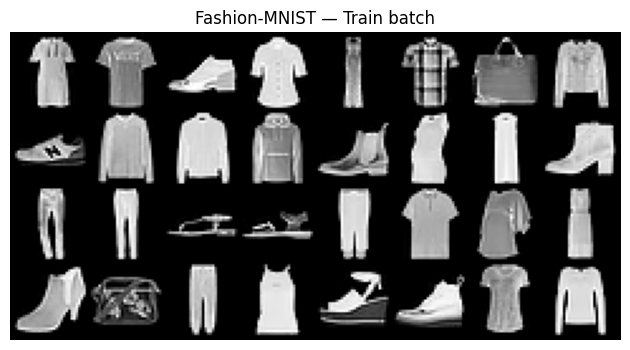

Shape: torch.Size([32, 1, 28, 28]) | min/max: 0.0 1.0
Labels: [3, 0, 9, 6, 3, 6, 8, 4, 7, 2, 4, 2, 9, 0, 3, 9, 1, 1, 5, 5, 1, 0, 6, 3, 9, 8, 1, 0, 5, 9, 0, 2]
Classes: ['Dress', 'T-shirt/top', 'Ankle boot', 'Shirt', 'Dress', 'Shirt', 'Bag', 'Coat', 'Sneaker', 'Pullover', 'Coat', 'Pullover', 'Ankle boot', 'T-shirt/top', 'Dress', 'Ankle boot', 'Trouser', 'Trouser', 'Sandal', 'Sandal', 'Trouser', 'T-shirt/top', 'Shirt', 'Dress', 'Ankle boot', 'Bag', 'Trouser', 'T-shirt/top', 'Sandal', 'Ankle boot', 'T-shirt/top', 'Pullover']


In [110]:
def show_batch(loader, n: int = 32, title: str = "Batch"):
    x, y = next(iter(loader))
    x = x[:n]
    y = y[:n]

    grid = make_grid(x, nrow=8, padding=2)
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(title)
    plt.show()

    print("Shape:", x.shape, "| min/max:", x.min().item(), x.max().item())
    print("Labels:", y.tolist())
    print("Classes:", [class_names[i] for i in y.tolist()])

show_batch(train_loader, n=32, title="Fashion-MNIST — Train batch")


# 4. Métriques d’évaluation

L’évaluation d’un VAE et d’un CVAE ne peut pas se limiter à la seule qualité visuelle des images générées.  
Ces modèles reposent sur un compromis entre **reconstruction fidèle**, **structuration du latent** et **capacité de génération**.

Les métriques retenues permettent donc d’évaluer trois aspects complémentaires :

1. la qualité de reconstruction des données,
2. l’utilisation effective de l’espace latent,
3. la qualité et la cohérence des images générées.

---

## 4.1 Reconstruction — BCE sur logits

On suppose une observation Bernoulli pixel-wise :

$$
p_\theta(x\mid z,y)=\prod_i \mathrm{Bernoulli}(x_i \mid \hat x_i),
\qquad \hat x = \sigma(\text{logits})
$$

La reconstruction est mesurée par :

$$
\mathrm{BCE}(x,\text{logits})=\sum_i -\left[x_i\log(\hat x_i)+(1-x_i)\log(1-\hat x_i)\right].
$$

**Pourquoi cette métrique est pertinente :**

- Elle correspond au **terme de reconstruction** de la $\beta$-ELBO utilisée pour l’entraînement.
- Elle mesure la capacité du modèle à préserver l’information contenue dans l’image d’entrée.
- Une BCE faible indique une bonne coopération entre encodeur et décodeur.

`bce_test` (plus petit = mieux)

---

## 4.2 Régularisation / usage du latent — KL

Pour $q_\phi(z\mid x,y)=\mathcal N(\mu, \mathrm{diag}(\sigma^2))$ et $p(z)=\mathcal N(0,I)$ :

$$
\mathrm{KL}(q\|p)=\frac{1}{2}\sum_{j=1}^d \left(\mu_j^2+\sigma_j^2-\log\sigma_j^2-1\right).
$$

**Pourquoi cette métrique est pertinente :**

- Elle correspond au **terme de régularisation** de la $\beta$-ELBO.
- Elle indique si le modèle encode réellement de l’information dans le latent.
- Une KL proche de 0 signale un **posterior collapse** (latent ignoré).

`kl_test` (diagnostic de collapse si proche de 0)

---

## 4.3 Diagnostic latent — Active Units (AU)

On mesure combien de dimensions latentes sont effectivement exploitées :

$$
\mathrm{AU} = \left|\{j : \mathbb{E}[\mathrm{KL}_j] > \tau\}\right|,
\quad \tau=0.01.
$$

**Pourquoi cette métrique est pertinente :**

- La KL globale peut être non nulle même si peu de dimensions sont utilisées.
- Les Active Units mesurent la richesse réelle de la représentation latente.
- Cela permet de comparer l’efficacité des architectures à exploiter tout l’espace latent.

`active_units` (plus grand = latent mieux exploité)

---

## 4.4 Génération — FMD (Feature Moment Distance)

Le FID classique étant coûteux, on utilise une approximation basée sur un classifieur auxiliaire $C_\omega$.

On extrait des features $f(x)\in\mathbb{R}^m$ sur :
- des images réelles,
- des images générées.

On compare moyenne et écart-type :

$$
\mathrm{FMD} = \|\mu_r-\mu_g\|_2^2 + \|\sigma_r-\sigma_g\|_2^2.
$$

**Pourquoi cette métrique est pertinente :**

- Elle compare des représentations sémantiques plutôt que des pixels.
- Elle évalue si les images générées possèdent des statistiques proches des vraies données.
- Elle mesure la qualité globale de la génération indépendamment de la reconstruction.

`fmd` (plus petit = mieux)

---

## 4.5 Cohérence conditionnelle (CVAE) — Accuracy conditionnelle

On génère $\tilde x \sim p_\theta(x\mid y)$ puis on classe via $C_\omega$ :

$$
\mathrm{Acc}_{cond}=\Pr(\arg\max C_\omega(\tilde x)=y).
$$

**Pourquoi cette métrique est pertinente :**

- Elle évalue si la condition $y$ est réellement prise en compte.
- Elle permet de vérifier que les images générées correspondent à la classe demandée.

`cond_acc` (plus grand = mieux)

---

## Synthèse

| Aspect évalué            | Métrique          | Rôle |
|--------------------------|-------------------|------|
| Fidélité reconstruction  | BCE               | Terme reconstruction de la $\beta$-ELBO |
| Organisation du latent   | KL                | Terme régularisation de la $\beta$-ELBO |
| Utilisation du latent    | Active Units      | Richesse de représentation |
| Qualité de génération    | FMD               | Réalisme des échantillons |
| Respect de la condition  | Cond. Accuracy    | Spécifique au CVAE |


In [111]:


def kl_diag_gaussian(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """KL(q||p) pour q=N(mu, diag(exp(logvar))) et p=N(0,I). Retourne (B,)"""
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=1)

@torch.no_grad()
def active_units(mu: torch.Tensor, logvar: torch.Tensor, threshold: float = 0.01) -> int:
    """Nombre de dimensions latentes effectivement utilisées (AU)."""
    kl_dim = 0.5 * (torch.exp(logvar) + mu**2 - 1.0 - logvar)  # (B,D)
    return int((kl_dim.mean(dim=0) > threshold).sum().item())

def fmd_from_features(feats_real: np.ndarray, feats_fake: np.ndarray) -> float:
    """Feature Moment Distance (FID-lite) via moments (moyenne, std) en features."""
    mu_r = feats_real.mean(axis=0)
    mu_g = feats_fake.mean(axis=0)
    std_r = feats_real.std(axis=0)
    std_g = feats_fake.std(axis=0)
    return float(np.sum((mu_r - mu_g)**2) + np.sum((std_r - std_g)**2))

@torch.no_grad()
def conditional_accuracy(aux_clf, x_gen: torch.Tensor, y_target: torch.Tensor,
                         device: torch.device) -> float:
    """Accuracy conditionnelle : Pr(argmax C(x_gen)=y_target)."""
    aux_clf.eval()
    x_gen = x_gen.to(device)
    y_target = y_target.to(device)
    pred = aux_clf(x_gen).argmax(dim=1)
    return float((pred == y_target).float().mean().item())

@torch.no_grad()
def classifier_confidence(aux_clf, x_gen: torch.Tensor, device: torch.device) -> float:
    """Confiance moyenne : E[max_k softmax(C(x_gen))]."""
    aux_clf.eval()
    x_gen = x_gen.to(device)
    logits = aux_clf(x_gen)
    p = torch.softmax(logits, dim=1)
    return float(p.max(dim=1).values.mean().item())

def balanced_labels(n: int, n_classes: int, device: torch.device) -> torch.Tensor:
    """Génère des labels équilibrés (0..n_classes-1 répétés) pour la génération conditionnelle."""
    y = torch.arange(n_classes, device=device).repeat((n + n_classes - 1) // n_classes)
    return y[:n]



# 5. Classifieur auxiliaire (features et cohérence conditionnelle)

Certaines métriques introduites précédemment (FMD et accuracy conditionnelle) nécessitent l’utilisation d’un réseau auxiliaire $C_\omega$.

Ce classifieur est entraîné sur Fashion-MNIST (10 classes) et possède deux rôles :

- fournir une représentation intermédiaire $f(x)$ des images (features extraites avant la couche de classification),
- permettre l’évaluation de la cohérence des images générées avec la classe demandée.

Ainsi, $C_\omega$ n’est pas utilisé pour améliorer le VAE/CVAE, mais uniquement comme **outil d’évaluation**.




In [112]:


class AuxCNN(nn.Module):
    def __init__(self, n_classes: int = 10, feat_dim: int = 128):
        super().__init__()
        self.feat_dim = feat_dim
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
        )
        self.fc_feat = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, feat_dim),
            nn.ReLU(),
        )
        self.fc_out = nn.Linear(feat_dim, n_classes)

    def features(self, x: torch.Tensor) -> torch.Tensor:
        h = self.conv(x)
        f = self.fc_feat(h)
        return f

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        f = self.features(x)
        return self.fc_out(f)

@torch.no_grad()
def aux_eval_acc(model: nn.Module, loader, device: torch.device) -> float:
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        correct += int((pred == y).sum().item())
        total += y.numel()
    return correct / max(total, 1)

def train_aux_classifier(aux_clf: nn.Module, train_loader, val_loader, device: torch.device,
                         epochs: int = 3, lr: float = 1e-3, weight_decay: float = 0.0):
    aux_clf = aux_clf.to(device)
    opt = torch.optim.Adam(aux_clf.parameters(), lr=lr, weight_decay=weight_decay)

    for ep in range(1, epochs + 1):
        aux_clf.train()
        total_loss = 0.0
        n = 0
        for x, y in tqdm(train_loader, desc=f"aux train ep {ep}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = aux_clf(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()
            bs = x.size(0)
            total_loss += loss.item() * bs
            n += bs

        val_acc = aux_eval_acc(aux_clf, val_loader, device)
        print(f"[aux] ep {ep}/{epochs} | loss={total_loss/max(n,1):.4f} | val_acc={val_acc:.4f}")

    return aux_clf


if "aux_clf" not in globals():
    aux_clf = AuxCNN(n_classes=10, feat_dim=128)


if not hasattr(aux_clf, "_trained"):
    aux_clf = train_aux_classifier(aux_clf, train_loader, val_loader, device=device, epochs=3, lr=1e-3)
    aux_clf._trained = True



# 6. Extraction des features pour le calcul du FMD

Les features $f(x)$ sont extraites via :

```

aux_clf.features(x)

```

Elles sont calculées sur :

- un sous-ensemble d’images réelles (jeu de test),
- un ensemble d’images générées par le modèle.

Ces représentations sont ensuite utilisées pour calculer la distance statistique FMD entre données réelles et données générées.




In [113]:

@torch.no_grad()
def get_features_from_loader(aux_clf: nn.Module, loader, device: torch.device, max_items: int = 2000) -> np.ndarray:
    aux_clf.eval()
    feats_list = []
    seen = 0
    for x, y in loader:
        x = x.to(device)
        f = aux_clf.features(x).detach().cpu().numpy()
        feats_list.append(f)
        seen += x.size(0)
        if seen >= max_items:
            break
    feats = np.concatenate(feats_list, axis=0)[:max_items]
    return feats

@torch.no_grad()
def get_features_from_tensor(aux_clf: nn.Module, x: torch.Tensor, device: torch.device) -> np.ndarray:
    aux_clf.eval()
    f = aux_clf.features(x.to(device)).detach().cpu().numpy()
    return f


# 7. Boucles d'entraînement / évaluation 

On définit :
- `reparameterize`
- `elbo_loss_bce_kl`
- `train_one_epoch`
- `evaluate_epoch`

Le modèle doit respecter :
- CVAE : `model(x, y) -> logits, mu, logvar`

On passe `conditional=True/False`.


In [114]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps

def elbo_loss_bce_kl(x: torch.Tensor, logits: torch.Tensor,
                     mu: torch.Tensor, logvar: torch.Tensor, beta: float = 1.0):
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction="none")
    bce = bce.view(bce.size(0), -1).sum(dim=1).mean()
    kl = kl_diag_gaussian(mu, logvar).mean()
    return bce + beta * kl, bce, kl

def train_one_epoch(model: nn.Module, loader, optimizer, beta: float, device: torch.device,
                    conditional: bool = False):
    model.train()
    tot_loss = tot_bce = tot_kl = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits, mu, logvar = model(x, y) if conditional else model(x)

        loss, bce, kl = elbo_loss_bce_kl(x, logits, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_bce  += bce.item() * bs
        tot_kl   += kl.item() * bs
        n += bs

    return {"loss": tot_loss / max(n,1), "bce": tot_bce / max(n,1), "kl": tot_kl / max(n,1)}

@torch.no_grad()
def evaluate_epoch(model: nn.Module, loader, beta: float, device: torch.device,
                   conditional: bool = False, au_threshold: float = 0.01):
    model.eval()
    tot_loss = tot_bce = tot_kl = 0.0
    n = 0
    au_val = None

    for i, (x, y) in enumerate(tqdm(loader, desc="eval", leave=False)):
        x, y = x.to(device), y.to(device)

        logits, mu, logvar = model(x, y) if conditional else model(x)

        loss, bce, kl = elbo_loss_bce_kl(x, logits, mu, logvar, beta=beta)

        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_bce  += bce.item() * bs
        tot_kl   += kl.item() * bs
        n += bs

        if i == 0:
            au_val = active_units(mu, logvar, threshold=au_threshold)

    return {
        "loss": tot_loss / max(n,1),
        "bce": tot_bce / max(n,1),
        "kl": tot_kl / max(n,1),
        "active_units": float(au_val if au_val is not None else np.nan),
    }


# 8. Visualisations 

On garde seulement :
- courbe loss train/val
- reconstructions (réel vs recon)
- génération conditionnelle (grid par classe)
- samples aléatoires


In [115]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def save_figure(fig, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path, bbox_inches="tight", dpi=150)
    plt.close(fig)

@torch.no_grad()
def plot_reconstructions(x: torch.Tensor, logits: torch.Tensor, title: str, save_path: str, n: int = 16):
    x = x[:n].cpu()
    xhat = torch.sigmoid(logits[:n]).cpu()
    grid = make_grid(torch.cat([x, xhat], dim=0), nrow=n, padding=2)
    fig = plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(title + " (haut: réel, bas: recon)")
    plt.show()
    save_figure(fig, save_path)

@torch.no_grad()
def plot_conditional_grid(logits_by_class, class_names, title: str, save_path: str, n_per_class: int = 6):
    rows = []
    for cls, logits in enumerate(logits_by_class):
        rows.append(torch.sigmoid(logits[:n_per_class]).cpu())
    grid = make_grid(torch.cat(rows, dim=0), nrow=n_per_class, padding=2)
    fig = plt.figure(figsize=(12, 10))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(title)
    plt.show()
    save_figure(fig, save_path)

@torch.no_grad()
def plot_samples_from_logits(logits: torch.Tensor, title: str, save_path: str, n: int = 64, nrow: int = 8):
    x = torch.sigmoid(logits[:n]).cpu()
    grid = make_grid(x, nrow=nrow, padding=2)
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(title)
    plt.show()
    save_figure(fig, save_path)


# 9. Logging des résultats

On crée :
- `results_df`
- `log_results(row)` qui écrit dans `results.csv`

But : comparer toutes les architectures facilement.


In [116]:


RESULTS_PATH = os.path.join(cfg.out_dir, "results_clean.csv")
os.makedirs(cfg.out_dir, exist_ok=True)


COLUMNS = [
    "arch_name", "epochs", "latent_dim", "beta",
    "bce_test", "kl_test", "active_units",
    "fmd", "cond_acc", "clf_conf"
]


results_df = pd.DataFrame(columns=COLUMNS)

def log_results(row: dict):
    global results_df
  
    row_filtered = {k: row.get(k, float("nan")) for k in COLUMNS}
    results_df = pd.concat([results_df, pd.DataFrame([row_filtered])], ignore_index=True)
    results_df.to_csv(RESULTS_PATH, index=False)

print("Logging vers :", RESULTS_PATH)


Logging vers : runs_vae_cvae/results_clean.csv


# 10. Protocole final : `run_cvae_protocol` (version optimisée)

Ce protocole fait :

1) Entraînement + sauvegarde du meilleur checkpoint (val loss)
2) Évaluation test (BCE, KL, AU)
3) Génération (FMD + cond_acc + conf du classif)
4) Plots 




In [117]:
from typing import Dict, Any

def run_cvae_protocol(
    model: nn.Module,
    arch_name: str,
    n_gen: int = None,
    real_subset: int = None,
    n_per_class_grid: int = 6,
    make_plots: bool = True,
) -> Dict[str, Any]:

    n_gen = int(n_gen if n_gen is not None else getattr(cfg, "n_gen", 1000))
    real_subset = int(real_subset if real_subset is not None else getattr(cfg, "fid_subset_real", 1000))

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    ckpt_dir = os.path.join(cfg.out_dir, "checkpoints")
    fig_dir  = os.path.join(cfg.out_dir, "figures")
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(fig_dir, exist_ok=True)

    best_val = float("inf")
    best_path = os.path.join(ckpt_dir, f"{arch_name}_best.pt")

    # ---- track loss + decomposition
    history = {
        "train_loss": [], "val_loss": [],
        "train_bce":  [], "val_bce":  [],
        "train_kl":   [], "val_kl":   [],
    }

    for ep in range(1, cfg.epochs + 1):
        tr = train_one_epoch(model, train_loader, optimizer, beta=cfg.beta, device=device, conditional=True)
        va = evaluate_epoch(model, val_loader, beta=cfg.beta, device=device, conditional=True)

        history["train_loss"].append(tr["loss"])
        history["val_loss"].append(va["loss"])
        history["train_bce"].append(tr["bce"])
        history["val_bce"].append(va["bce"])
        history["train_kl"].append(tr["kl"])
        history["val_kl"].append(va["kl"])

        print(
            f"[{arch_name}] ep {ep:02d}/{cfg.epochs} | "
            f"train: loss={tr['loss']:.3f} bce={tr['bce']:.3f} kl={tr['kl']:.3f} | "
            f"val: loss={va['loss']:.3f} bce={va['bce']:.3f} kl={va['kl']:.3f}"
        )

        if va["loss"] < best_val:
            best_val = va["loss"]
            torch.save(model.state_dict(), best_path)

    print(f"[{arch_name}] best val={best_val:.4f} | saved: {best_path}")

    if make_plots:
        # ---- loss curve
        fig = plt.figure(figsize=(8, 4))
        plt.plot(history["train_loss"], label="train")
        plt.plot(history["val_loss"], label="val")
        plt.title(f"{arch_name} — loss")
        plt.xlabel("epoch")
        plt.legend()
        plt.show()
        save_figure(fig, os.path.join(fig_dir, f"{arch_name}_loss.png"))

        # ---- KL curve (requested)
        fig = plt.figure(figsize=(8, 4))
        plt.plot(history["train_kl"], label="train KL")
        plt.plot(history["val_kl"], label="val KL")
        plt.title(f"{arch_name} — KL term")
        plt.xlabel("epoch")
        plt.legend()
        plt.show()
        save_figure(fig, os.path.join(fig_dir, f"{arch_name}_kl.png"))

        # (optional but often useful) BCE curve
        fig = plt.figure(figsize=(8, 4))
        plt.plot(history["train_bce"], label="train BCE")
        plt.plot(history["val_bce"], label="val BCE")
        plt.title(f"{arch_name} — reconstruction (BCE)")
        plt.xlabel("epoch")
        plt.legend()
        plt.show()
        save_figure(fig, os.path.join(fig_dir, f"{arch_name}_bce.png"))

    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()

    test_stats = evaluate_epoch(model, test_loader, beta=cfg.beta, device=device, conditional=True)
    print(f"[{arch_name}] test:", test_stats)

    if make_plots:
        x, y = next(iter(test_loader))
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits, mu, logvar = model(x, y)

        plot_reconstructions(
            x.cpu(), logits.cpu(),
            title=f"{arch_name} — recon",
            save_path=os.path.join(fig_dir, f"{arch_name}_recon.png"),
            n=16
        )

    feats_real = get_features_from_loader(aux_clf, test_loader, device=device, max_items=real_subset)

    y_gen = balanced_labels(n_gen, n_classes=10, device=device)
    logits_gen = model.sample(y_gen, device=device)           # (N,1,28,28) logits
    x_gen = torch.sigmoid(logits_gen).detach()                # (N,1,28,28) in [0,1]

    feats_fake = get_features_from_tensor(aux_clf, x_gen, device=device)
    fmd = fmd_from_features(feats_real, feats_fake)

    cond_acc = conditional_accuracy(aux_clf, x_gen, y_gen, device=device)
    clf_conf = classifier_confidence(aux_clf, x_gen, device=device)

    print(f"[{arch_name}] gen: fmd={fmd:.3f} | cond_acc={cond_acc:.3f} | clf_conf={clf_conf:.3f}")

    if make_plots:
        plot_samples_from_logits(
            logits_gen.detach().cpu(),
            title=f"{arch_name} — random conditional samples",
            save_path=os.path.join(fig_dir, f"{arch_name}_samples.png"),
            n=64, nrow=8
        )

        logits_by_class = []
        for cls in range(10):
            y_cls = torch.full((n_per_class_grid,), cls, dtype=torch.long, device=device)
            logits_cls = model.sample(y_cls, device=device)
            logits_by_class.append(logits_cls.detach().cpu())

        plot_conditional_grid(
            logits_by_class=logits_by_class,
            class_names=class_names,
            title=f"{arch_name} — conditional grid",
            save_path=os.path.join(fig_dir, f"{arch_name}_cond_grid.png"),
            n_per_class=n_per_class_grid
        )

    row = {
    "arch_name": arch_name,
    "epochs": int(cfg.epochs),
    "latent_dim": int(cfg.latent_dim),
    "beta": float(cfg.beta),

    "bce_test": float(test_stats["bce"]),
    "kl_test": float(test_stats["kl"]),
    "active_units": float(test_stats["active_units"]),

    "fmd": float(fmd),
    "cond_acc": float(cond_acc),
    "clf_conf": float(clf_conf),
}

    log_results(row)
    return row


## 11.0 Éléments communs à toutes les architectures CVAE

Toutes les architectures partagent **exactement la même base**.
La seule chose qui change est **la manière d’injecter la condition $y$**.

---

### 11.0.1 Structure encodeur–décodeur identique

* Encodeur convolutionnel (3 conv stride 2) :
  $$
  (1,28,28) \rightarrow (128,4,4)
  $$

* Flatten + couches fully-connected pour produire :
  $$
  \mu(x,y), \quad \log\sigma^2(x,y)
  $$

* Espace latent identique :
  $$
  z \in \mathbb{R}^{16}
  $$

* Décodeur convolutionnel (ConvTranspose2d ou blocs résiduels) reconstruisant :
  $$
  (1,28,28)
  $$
  en **logits**.

---

### 11.0.2 Fonction d’activation commune : ReLU

Partout (sauf en sortie) :
$$
\mathrm{ReLU}(x)=\max(0,x)
$$

**Pourquoi :**

* évite le vanishing gradient (contrairement à sigmoid/tanh),
* rend l’entraînement plus stable avec Adam,
* standard dans les CNN convolutionnels,
* introduit la non-linéarité nécessaire pour modéliser des structures visuelles complexes.

---

### 11.0.3 Sortie en logits (pas de sigmoid)

Aucune sigmoid dans le modèle.
On utilise directement :
$$
\mathrm{BCEWithLogits}(x,\text{logits})
$$
plus stable numériquement.

---

### 11.0.4 Tête latente identique

Même structure pour produire :
$$
\mu \quad \text{et} \quad \log\sigma^2.
$$

---

### 11.0.5 Ce qui change entre les architectures

**Uniquement** la façon d’injecter $y$ :

* one-hot concaténé,
* embedding multi-injection,
* FiLM,
* Conditional BatchNorm,
* blocs résiduels conditionnés.


# 11. Architecture 1 — CVAE (Concaténation One-Hot)

Cette architecture implémente un **Conditional Variational Autoencoder** en utilisant la forme la plus classique du conditionnement : la concaténation du label encodé en **one-hot**.

## 11.1 Principe du conditionnement

Le label $y$ est représenté par :

$$
\mathrm{onehot}(y)\in{0,1}^{10}
$$

Ce vecteur est injecté à deux endroits :

* dans l’encodeur, après le *flatten* des features convolutives ;
* dans le décodeur, concaténé au latent $z$.

Cela force le modèle à apprendre :

$$
q_\phi(z \mid x,y)
\qquad\text{et}\qquad
p_\theta(x \mid z,y).
$$

---

## 11.2 Schéma — Encodeur

```text
Entrée x : (1 x 28 x 28)
   |
   v
+-----------------------------+
| Conv1 1->32  k=3  s=2       |
+-----------------------------+
   |
   v
(32 x 14 x 14)
   |
   v
+-----------------------------+
| Conv2 32->64  k=3  s=2      |
+-----------------------------+
   |
   v
(64 x 7 x 7)
   |
   v
+-----------------------------+
| Conv3 64->128  k=3  s=2     |
+-----------------------------+
   |
   v
(128 x 4 x 4)
   |
   v
Flatten -> 2048
   |
   v
Concat [2048 ; onehot(y)]
   |
   +---------------+----------------+
   |               |
   v               v
fc_mu          fc_logvar
   |               |
   +-------+-------+
           |
           v
Reparameterization -> z
```

---

## Décodeur

```text
z : (latent_dim)
   |
   v
Concat [z ; onehot(y)]
   |
   v
FC -> 2048
   |
   v
Reshape -> (128 x 4 x 4)
   |
   v
Deconv1 128->64   (4 -> 7)
   |
   v
Deconv2 64->32    (7 -> 14)
   |
   v
Deconv3 32->1     (14 -> 28)
   |
   v
Logits (1 x 28 x 28)
```

---

**Sohn, K., Yan, X., Lee, H. (NeurIPS 2015)**
*Learning Structured Output Representation using Deep Conditional Generative Models*


## 11.3 Utilitaires : one-hot des labels

On code une fonction `to_onehot(y, n_classes=10)` pour créer $\mathrm{onehot}(y)$.
On s’en sert dans :
- l’encodeur : concat avec features aplaties
- le décodeur : concat avec $z$


In [118]:
def to_onehot(y: torch.Tensor, n_classes: int = 10) -> torch.Tensor:
    """
    y: (B,) int64
    return: (B, n_classes) float32
    """
    return F.one_hot(y.long(), num_classes=n_classes).float()


In [119]:
class CVAE_ConcatOneHot(nn.Module):
    def __init__(self, latent_dim: int = 16, n_classes: int = 10):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes

        # Encoder: (B,1,28,28) -> (B,128,4,4)
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),   # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 4x4
            nn.ReLU(),
        )

        self.enc_fc = nn.Sequential(
            nn.Flatten(),                               # 128*4*4 = 2048
        )

        self.fc_shared = nn.Sequential(
            nn.Linear(128 * 4 * 4 + n_classes, 256),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder: [z; onehot] -> (B,128,4,4) -> (B,1,28,28) logits
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 4 * 4),
            nn.ReLU(),
        )

        # 4 -> 7 -> 14 -> 28 avec ConvTranspose2d
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0), # 4->7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14->28
            # logits (pas de sigmoid)
        )

    def encode(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.enc(x)
        h = self.enc_fc(h)  # (B,2048)
        y_oh = to_onehot(y, self.n_classes).to(h.device)
        h = torch.cat([h, y_oh], dim=1)  # (B, 2048+10)
        h = self.fc_shared(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        y_oh = to_onehot(y, self.n_classes).to(z.device)
        zy = torch.cat([z, y_oh], dim=1)
        h = self.dec_fc(zy)
        h = h.view(-1, 128, 4, 4)
        logits = self.dec(h)
        return logits

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x, y)
        z = reparameterize(mu, logvar)
        logits = self.decode(z, y)
        return logits, mu, logvar

    @torch.no_grad()
    def sample(self, y: torch.Tensor, device: torch.device) -> torch.Tensor:
        """
        y: (N,) labels demandés
        retourne logits (N,1,28,28)
        """
        self.eval()
        y = y.to(device)
        z = torch.randn(y.size(0), self.latent_dim, device=device)
        logits = self.decode(z, y)
        return logits


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 01/15 | train: loss=286.780 bce=277.611 kl=9.170 | val: loss=255.408 bce=245.179 kl=10.229


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 02/15 | train: loss=249.290 bce=238.953 kl=10.337 | val: loss=246.282 bce=235.671 kl=10.611


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 03/15 | train: loss=244.118 bce=233.634 kl=10.484 | val: loss=243.364 bce=232.677 kl=10.687


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 04/15 | train: loss=241.765 bce=231.230 kl=10.535 | val: loss=241.362 bce=230.877 kl=10.485


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 05/15 | train: loss=240.096 bce=229.578 kl=10.519 | val: loss=241.055 bce=230.509 kl=10.546


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 06/15 | train: loss=239.103 bce=228.583 kl=10.519 | val: loss=239.817 bce=229.270 kl=10.547


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 07/15 | train: loss=238.161 bce=227.673 kl=10.488 | val: loss=238.975 bce=228.168 kl=10.807


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 08/15 | train: loss=237.507 bce=227.062 kl=10.445 | val: loss=238.079 bce=227.573 kl=10.506


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 09/15 | train: loss=236.957 bce=226.528 kl=10.430 | val: loss=237.599 bce=226.996 kl=10.603


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 10/15 | train: loss=236.533 bce=226.129 kl=10.404 | val: loss=237.438 bce=227.291 kl=10.147


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 11/15 | train: loss=236.165 bce=225.767 kl=10.398 | val: loss=237.055 bce=226.767 kl=10.288


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 12/15 | train: loss=235.729 bce=225.328 kl=10.402 | val: loss=236.987 bce=226.643 kl=10.344


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 13/15 | train: loss=235.445 bce=225.022 kl=10.423 | val: loss=236.399 bce=226.096 kl=10.303


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 14/15 | train: loss=235.170 bce=224.767 kl=10.403 | val: loss=236.181 bce=225.813 kl=10.368


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_concat_onehot] ep 15/15 | train: loss=234.860 bce=224.432 kl=10.427 | val: loss=236.058 bce=225.311 kl=10.747
[CVAE_concat_onehot] best val=236.0580 | saved: runs_vae_cvae/checkpoints/CVAE_concat_onehot_best.pt


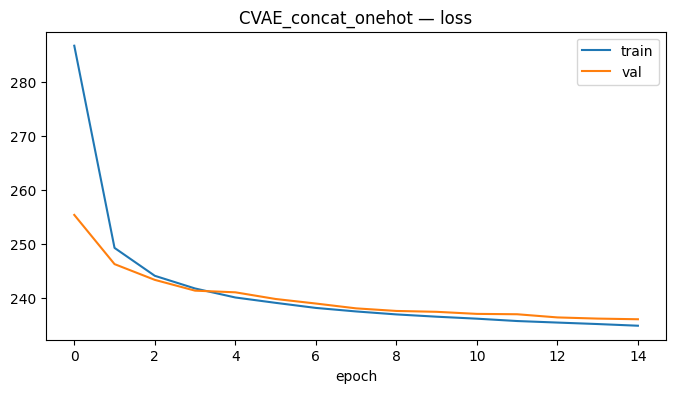

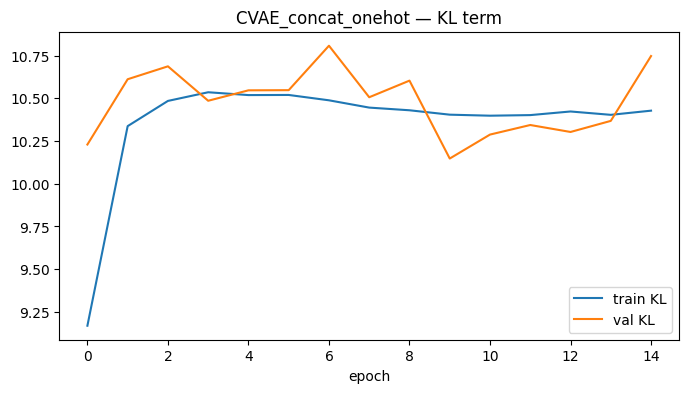

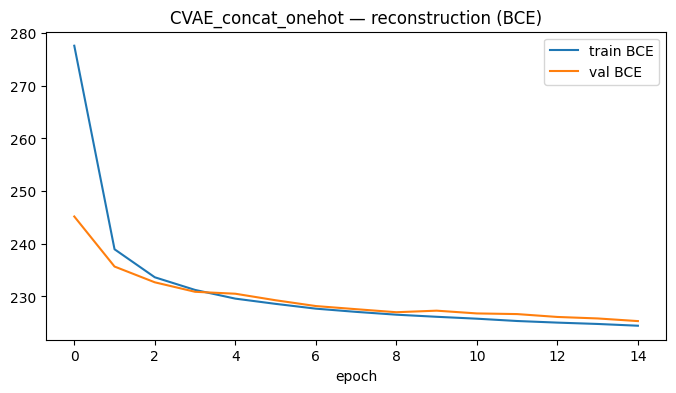

eval:   0%|          | 0/79 [00:00<?, ?it/s]

[CVAE_concat_onehot] test: {'loss': 237.055962890625, 'bce': 226.39326274414063, 'kl': 10.66270023803711, 'active_units': 9.0}


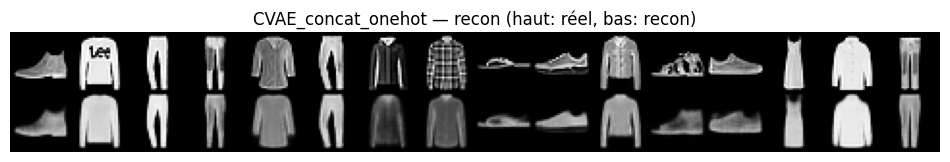

[CVAE_concat_onehot] gen: fmd=67.791 | cond_acc=0.752 | clf_conf=0.763


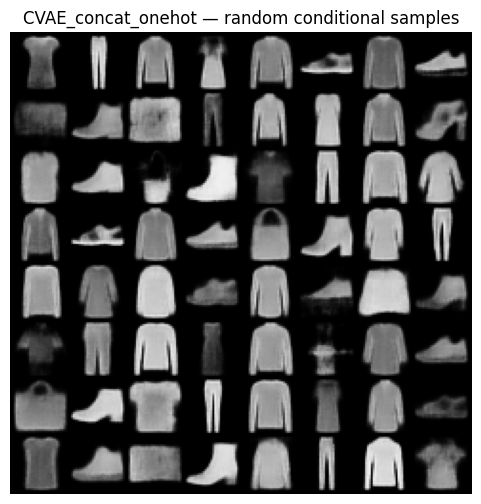

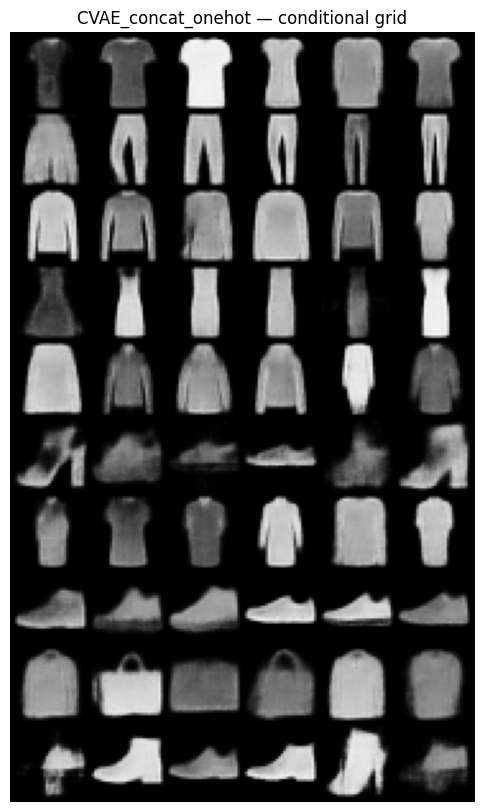

/tmp/ipykernel_52957/3409892982.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row_filtered])], ignore_index=True)


,arch_name,epochs,latent_dim,beta,bce_test,kl_test,active_units,fmd,cond_acc,clf_conf
0,CVAE_concat_onehot,15,16,1.0,226.393263,10.6627,9.0,67.790604,0.7515,0.762681


In [120]:
ARCH_NAME = "CVAE_concat_onehot"
model_cvae1 = CVAE_ConcatOneHot(latent_dim=cfg.latent_dim, n_classes=10)
row1 = run_cvae_protocol(model_cvae1, ARCH_NAME)
results_df.tail(3)


# 12. Architecture 2 — CVAE (Embedding + injection multi-couches)

## 12.1 Pourquoi cette architecture ?

L’architecture 1 (concat one-hot) est simple mais la condition $y$ peut être “faiblement” exploitée :

* one-hot = représentation sparse (10 dimensions)
* si injecté une seule fois, le réseau peut perdre l’info conditionnelle en profondeur

Ici on remplace le one-hot par un **embedding appris** :
$$
e(y)=\mathrm{Embed}(y)\in\mathbb{R}^{d_e}
$$
et on **ré-injecte** $e(y)$ plusieurs fois dans l’encodeur et le décodeur.

---

## 12.2 Schéma 

### Encodeur

```text
Entrée x : (1 x 28 x 28)
   |
   v
+-----------------------------+
| Conv1 1->32  k=3  s=2       |
+-----------------------------+
   |
   v
(32 x 14 x 14)
   |
   v
+-----------------------------+
| Conv2 32->64  k=3  s=2      |
+-----------------------------+
   |
   v
(64 x 7 x 7)
   |
   v
+-----------------------------+
| Conv3 64->128  k=3  s=2     |
+-----------------------------+
   |
   v
(128 x 4 x 4)
   |
   v
Flatten -> 2048
   |
   +------------------------------+
   |                              |
   v                              v
Concat [2048 ; e(y)]        e(y)=Embedding(y) dim=d_e
   |
   v
FC1: (2048+d_e) -> 256 + ReLU
   |
   v
Concat [256 ; e(y)]
   |
   v
FC2: (256+d_e) -> 256 + ReLU
   |
   +---------------+----------------+
   |               |
   v               v
fc_mu: 256->latent_dim     fc_logvar: 256->latent_dim
   |               |
   +-------+-------+
           |
           v
Reparameterization -> z
```

### Décodeur

```text
z : (latent_dim)
   |
   +------------------------------+
   |                              |
   v                              v
Concat [z ; e(y)]           e(y)=Embedding(y) dim=d_e
   |
   v
FC1: (latent_dim+d_e) -> 256 + ReLU
   |
   v
Concat [256 ; e(y)]
   |
   v
FC2: (256+d_e) -> 2048 + ReLU
   |
   v
Reshape -> (128 x 4 x 4)
   |
   v
+-----------------------------+
| Deconv1 128->64   (4 -> 7) |
+-----------------------------+
   |
   v
+-----------------------------+
| Deconv2 64->32    (7 -> 14)|
+-----------------------------+
   |
   v
+-----------------------------+
| Deconv3 32->1     (14->28) |
+-----------------------------+
   |
   v
Sortie logits : (1 x 28 x 28)
```

---

**Sohn, K., Yan, X., Lee, H. (NeurIPS 2015)** — *Learning Structured Output Representation using Deep Conditional Generative Models*

**Mikolov, T. et al. (2013)** — *Distributed Representations of Words and Phrases and their Compositionality*

**Dumoulin, V., Shlens, J., Kudlur, M. (ICLR 2017)** — *A Learned Representation for Artistic Style*


In [121]:
from typing import Tuple

class CVAE_EmbeddingMultiInject(nn.Module):
    def __init__(self, latent_dim: int = 16, n_classes: int = 10, emb_dim: int = 16):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.emb_dim = emb_dim

        # e(y) = Embedding(y)
        self.embed = nn.Embedding(n_classes, emb_dim)

        # Encoder CNN: (B,1,28,28) -> (B,128,4,4)
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),   # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 4x4
            nn.ReLU(),
        )
        self.enc_flat = nn.Flatten()  # 2048

        # Encoder MLP (injection multi-couches)
        self.enc_fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4 + emb_dim, 256),
            nn.ReLU(),
        )
        self.enc_fc2 = nn.Sequential(
            nn.Linear(256 + emb_dim, 256),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder MLP (injection multi-couches)
        self.dec_fc1 = nn.Sequential(
            nn.Linear(latent_dim + emb_dim, 256),
            nn.ReLU(),
        )
        self.dec_fc2 = nn.Sequential(
            nn.Linear(256 + emb_dim, 128 * 4 * 4),
            nn.ReLU(),
        )

        # Decoder deconv: 4 -> 7 -> 14 -> 28
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0), # 4->7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14->28
        )

    def encode(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.enc(x)
        h = self.enc_flat(h)            # (B,2048)
        ey = self.embed(y.long())       # (B,emb_dim)

        h1 = self.enc_fc1(torch.cat([h, ey], dim=1))
        h2 = self.enc_fc2(torch.cat([h1, ey], dim=1))

        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def decode(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        ey = self.embed(y.long())
        g1 = self.dec_fc1(torch.cat([z, ey], dim=1))
        g2 = self.dec_fc2(torch.cat([g1, ey], dim=1))
        g2 = g2.view(-1, 128, 4, 4)
        logits = self.dec(g2)
        return logits

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x, y)
        z = reparameterize(mu, logvar)
        logits = self.decode(z, y)
        return logits, mu, logvar

    @torch.no_grad()
    def sample(self, y: torch.Tensor, device: torch.device) -> torch.Tensor:
        self.eval()
        y = y.to(device)
        z = torch.randn(y.size(0), self.latent_dim, device=device)
        logits = self.decode(z, y)
        return logits


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 01/15 | train: loss=280.141 bce=273.981 kl=6.160 | val: loss=252.167 bce=244.928 kl=7.239


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 02/15 | train: loss=248.073 bce=240.965 kl=7.107 | val: loss=246.693 bce=239.676 kl=7.018


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 03/15 | train: loss=244.712 bce=237.510 kl=7.203 | val: loss=244.365 bce=237.017 kl=7.348


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 04/15 | train: loss=242.891 bce=235.589 kl=7.302 | val: loss=243.361 bce=235.709 kl=7.652


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 05/15 | train: loss=241.740 bce=234.327 kl=7.413 | val: loss=242.506 bce=234.898 kl=7.608


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 06/15 | train: loss=240.917 bce=233.438 kl=7.479 | val: loss=241.634 bce=234.334 kl=7.300


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 07/15 | train: loss=240.278 bce=232.761 kl=7.516 | val: loss=241.073 bce=233.375 kl=7.699


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 08/15 | train: loss=239.692 bce=232.122 kl=7.570 | val: loss=240.871 bce=233.322 kl=7.549


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 09/15 | train: loss=239.322 bce=231.718 kl=7.604 | val: loss=240.291 bce=232.516 kl=7.775


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 10/15 | train: loss=239.013 bce=231.357 kl=7.656 | val: loss=239.898 bce=231.993 kl=7.905


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 11/15 | train: loss=238.644 bce=230.962 kl=7.682 | val: loss=239.699 bce=231.759 kl=7.940


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 12/15 | train: loss=238.393 bce=230.656 kl=7.737 | val: loss=239.622 bce=231.871 kl=7.752


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 13/15 | train: loss=238.110 bce=230.267 kl=7.842 | val: loss=239.048 bce=230.816 kl=8.232


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 14/15 | train: loss=237.646 bce=229.561 kl=8.085 | val: loss=238.633 bce=230.220 kl=8.413


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] ep 15/15 | train: loss=237.001 bce=228.645 kl=8.356 | val: loss=238.131 bce=229.456 kl=8.675
[CVAE_emb_multi_inject] best val=238.1307 | saved: runs_vae_cvae/checkpoints/CVAE_emb_multi_inject_best.pt


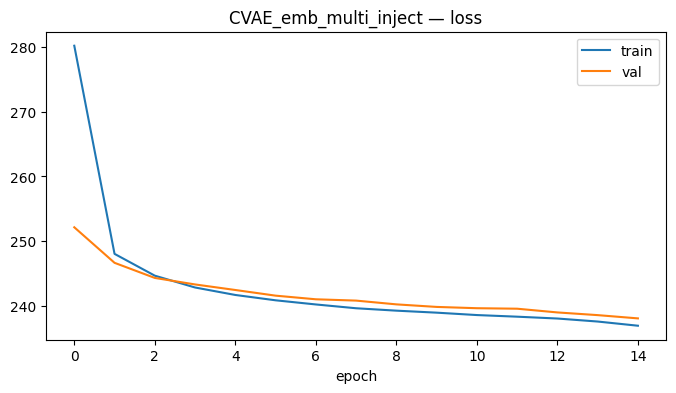

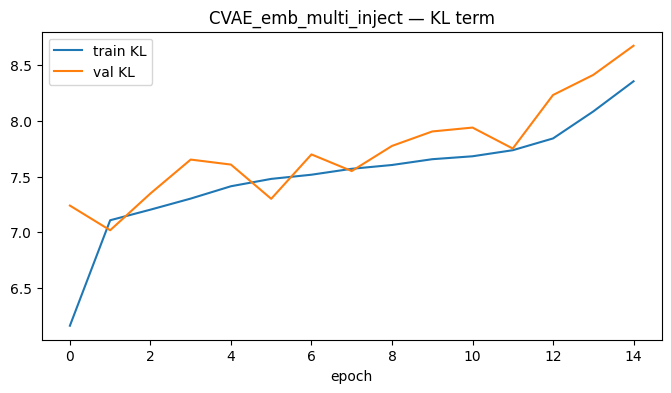

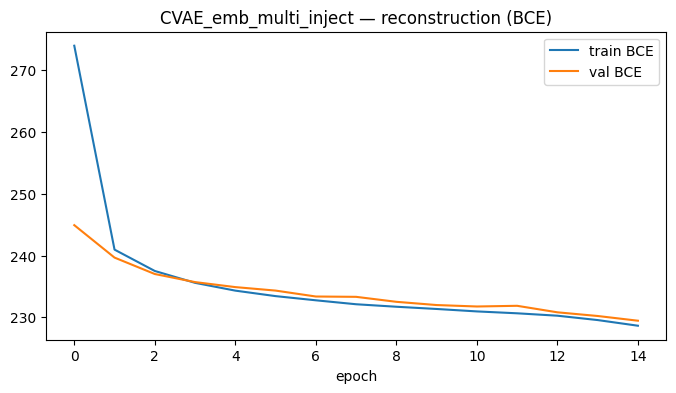

eval:   0%|          | 0/79 [00:00<?, ?it/s]

[CVAE_emb_multi_inject] test: {'loss': 239.134061328125, 'bce': 230.51305563964843, 'kl': 8.621005584716796, 'active_units': 7.0}


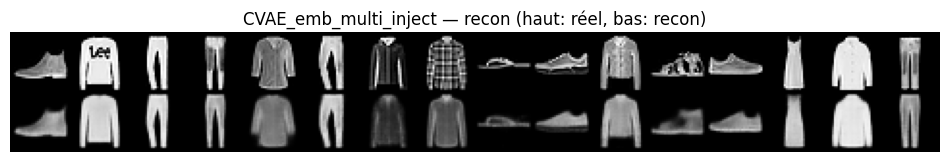

[CVAE_emb_multi_inject] gen: fmd=56.509 | cond_acc=0.868 | clf_conf=0.816


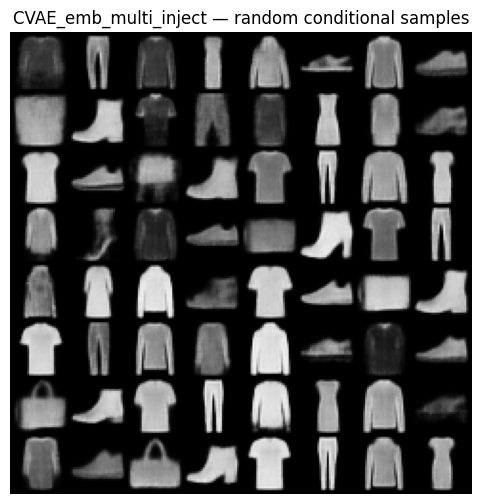

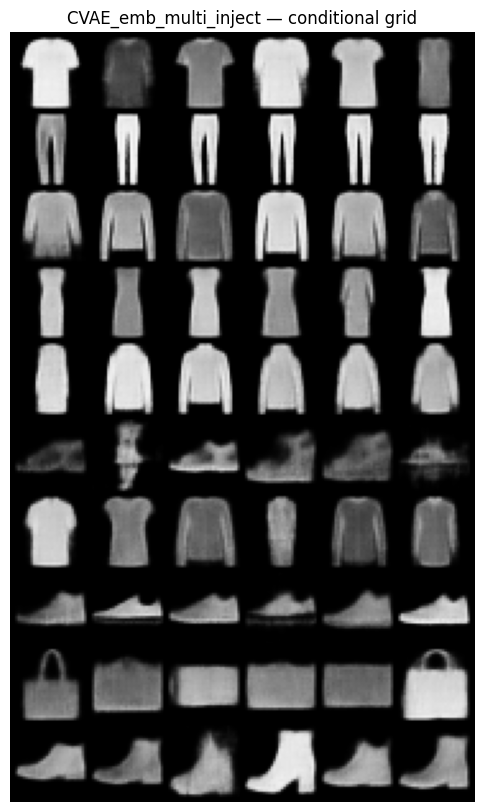

,arch_name,epochs,latent_dim,beta,bce_test,kl_test,active_units,fmd,cond_acc,clf_conf
0,CVAE_concat_onehot,15,16,1.0,226.393263,10.662700,9.0,67.790604,0.7515,0.762681
1,CVAE_emb_multi_inject,15,16,1.0,230.513056,8.621006,7.0,56.508514,0.8675,0.816247


In [122]:
ARCH2_NAME = "CVAE_emb_multi_inject"

model_cvae2 = CVAE_EmbeddingMultiInject(
    latent_dim=cfg.latent_dim,
    n_classes=10,
    emb_dim=16
)

row2 = run_cvae_protocol(model_cvae2, ARCH2_NAME)
results_df.tail(5)


Voici **exactement le même format** que tes précédentes sections, avec **les refs en gras**.

---

# 13. Architecture 3 — CVAE (FiLM : Feature-wise Linear Modulation)

## 13.1 Pourquoi cette architecture ?

Au lieu de concaténer $y$ (one-hot ou embedding) uniquement dans les couches fully-connected,
on **injecte la condition directement dans les feature maps convolutionnelles**.

On apprend un embedding :

$$
e(y)=\mathrm{Embed}(y)
$$

qui sert à produire, pour chaque bloc convolutionnel $k$, des paramètres :

$$
\gamma_k(y),;\beta_k(y)
$$

appliqués par une modulation FiLM :

$$
\mathrm{FiLM}(h_k,y)=\gamma_k(y)\odot h_k+\beta_k(y)
$$

où $h_k\in\mathbb{R}^{B\times C\times H\times W}$.

La condition agit donc **à l’intérieur même des représentations spatiales**, ce qui est
beaucoup plus fort qu’une simple concaténation.

Cela force le modèle à apprendre :

$$
q_\phi(z\mid x,y)
\qquad\text{et}\qquad
p_\theta(x\mid z,y)
$$

avec une dépendance conditionnelle **dans toutes les couches convolutionnelles**.

---

## 13.2 Schéma — Encoder

```text
Entrée x : (1 x 28 x 28)
   |
   v
Conv1 1->32  k=3 s=2
   |
   v
FiLM(y) -> (32 x 14 x 14)
   |
   v
Conv2 32->64  k=3 s=2
   |
   v
FiLM(y) -> (64 x 7 x 7)
   |
   v
Conv3 64->128  k=3 s=2
   |
   v
FiLM(y) -> (128 x 4 x 4)
   |
   v
Flatten -> FC
   |
   +---------------+----------------+
   |               |
   v               v
fc_mu            fc_logvar
   |               |
   +-------+-------+
           |
           v
Reparameterization -> z
```

---

## Décodeur

```text
z : (latent_dim)
   |
   v
z + e(y)
   |
   v
FC -> reshape (128 x 4 x 4)
   |
   v
Deconv1 128->64   (4 -> 7)
   |
   v
FiLM(y)
   |
   v
Deconv2 64->32    (7 -> 14)
   |
   v
FiLM(y)
   |
   v
Deconv3 32->1     (14 -> 28)
   |
   v
Logits (1 x 28 x 28)
```

---

**Références**

* **CVAE (cadre théorique)** — **Sohn, K., Yan, X., Lee, H. (NeurIPS 2015)**, *Learning Structured Output Representation using Deep Conditional Generative Models*

* **FiLM : Feature-wise Linear Modulation** — **Perez, E. et al. (AAAI 2018)**, *FiLM: Visual Reasoning with a General Conditioning Layer*


In [123]:
class FiLM(nn.Module):
    """
    FiLM layer: h -> gamma(y)*h + beta(y)
    gamma, beta sont produits à partir d'un embedding de y.
    """
    def __init__(self, n_classes: int, emb_dim: int, n_channels: int):
        super().__init__()
        self.embed = nn.Embedding(n_classes, emb_dim)
        self.to_gamma_beta = nn.Sequential(
            nn.Linear(emb_dim, 2 * n_channels)  # concat [gamma, beta]
        )

    def forward(self, h: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # h: (B,C,H,W), y: (B,)
        ey = self.embed(y.long())                 # (B,emb_dim)
        gb = self.to_gamma_beta(ey)               # (B,2C)
        C = h.size(1)
        gamma, beta = gb[:, :C], gb[:, C:]        # (B,C), (B,C)

        # reshape pour broadcast
        gamma = gamma.unsqueeze(-1).unsqueeze(-1) # (B,C,1,1)
        beta  = beta.unsqueeze(-1).unsqueeze(-1)  # (B,C,1,1)
        return gamma * h + beta


In [124]:
from typing import Tuple

class CVAE_FiLM(nn.Module):
    def __init__(self, latent_dim: int = 16, n_classes: int = 10, emb_dim: int = 16):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.emb_dim = emb_dim

        # Encoder convs
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)   # 14x14
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 7x7
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 4x4

        self.film1 = FiLM(n_classes, emb_dim, 32)
        self.film2 = FiLM(n_classes, emb_dim, 64)
        self.film3 = FiLM(n_classes, emb_dim, 128)

        self.enc_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder FC (on concat z avec embedding(y) comme point d'entrée)
        self.embed_dec = nn.Embedding(n_classes, emb_dim)
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim + emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 4 * 4),
            nn.ReLU(),
        )

        # Decoder deconvs
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0) # 4->7
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # 7->14
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)   # 14->28

        self.film4 = FiLM(n_classes, emb_dim, 64)
        self.film5 = FiLM(n_classes, emb_dim, 32)

    def encode(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = F.relu(self.film1(self.conv1(x), y))
        h = F.relu(self.film2(self.conv2(h), y))
        h = F.relu(self.film3(self.conv3(h), y))

        h = self.enc_fc(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        ey = self.embed_dec(y.long())
        h = self.dec_fc(torch.cat([z, ey], dim=1))
        h = h.view(-1, 128, 4, 4)

        h = F.relu(self.film4(self.deconv1(h), y))
        h = F.relu(self.film5(self.deconv2(h), y))
        logits = self.deconv3(h)  # logits
        return logits

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x, y)
        z = reparameterize(mu, logvar)
        logits = self.decode(z, y)
        return logits, mu, logvar

    @torch.no_grad()
    def sample(self, y: torch.Tensor, device: torch.device) -> torch.Tensor:
        self.eval()
        y = y.to(device)
        z = torch.randn(y.size(0), self.latent_dim, device=device)
        return self.decode(z, y)


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 01/15 | train: loss=325.141 bce=324.885 kl=0.256 | val: loss=302.619 bce=300.279 kl=2.340


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 02/15 | train: loss=281.358 bce=278.571 kl=2.787 | val: loss=267.379 bce=263.142 kl=4.237


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 03/15 | train: loss=260.164 bce=255.551 kl=4.612 | val: loss=258.374 bce=253.766 kl=4.609


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 04/15 | train: loss=255.795 bce=251.323 kl=4.471 | val: loss=255.796 bce=251.355 kl=4.441


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 05/15 | train: loss=254.220 bce=249.844 kl=4.376 | val: loss=254.817 bce=250.336 kl=4.481


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 06/15 | train: loss=253.257 bce=248.870 kl=4.387 | val: loss=254.158 bce=249.717 kl=4.441


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 07/15 | train: loss=252.698 bce=248.282 kl=4.415 | val: loss=253.770 bce=249.273 kl=4.497


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 08/15 | train: loss=252.363 bce=247.921 kl=4.442 | val: loss=253.760 bce=249.310 kl=4.450


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 09/15 | train: loss=251.967 bce=247.497 kl=4.470 | val: loss=253.292 bce=248.789 kl=4.504


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 10/15 | train: loss=251.650 bce=247.146 kl=4.503 | val: loss=252.536 bce=248.029 kl=4.507


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 11/15 | train: loss=251.376 bce=246.857 kl=4.519 | val: loss=252.683 bce=248.058 kl=4.626


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 12/15 | train: loss=251.156 bce=246.612 kl=4.544 | val: loss=252.058 bce=247.541 kl=4.517


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 13/15 | train: loss=250.884 bce=246.321 kl=4.563 | val: loss=252.214 bce=247.687 kl=4.527


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 14/15 | train: loss=250.681 bce=246.095 kl=4.586 | val: loss=252.230 bce=247.712 kl=4.518


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_film] ep 15/15 | train: loss=250.506 bce=245.901 kl=4.605 | val: loss=252.062 bce=247.370 kl=4.692
[CVAE_film] best val=252.0579 | saved: runs_vae_cvae/checkpoints/CVAE_film_best.pt


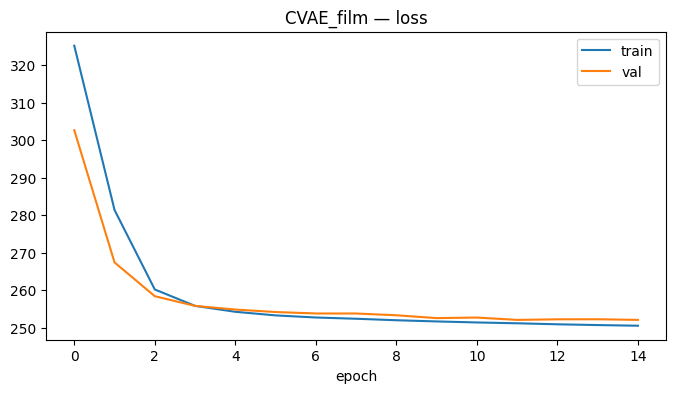

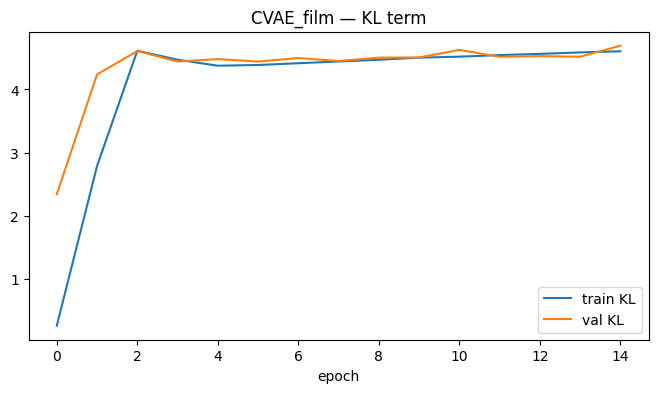

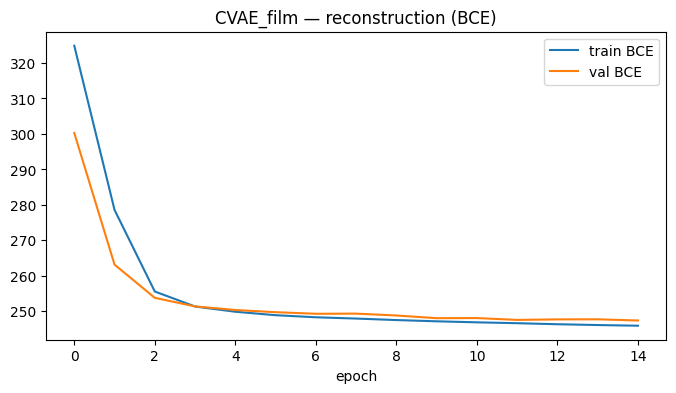

eval:   0%|          | 0/79 [00:00<?, ?it/s]

[CVAE_film] test: {'loss': 252.6559352783203, 'bce': 248.15764704589844, 'kl': 4.4982879379272465, 'active_units': 2.0}


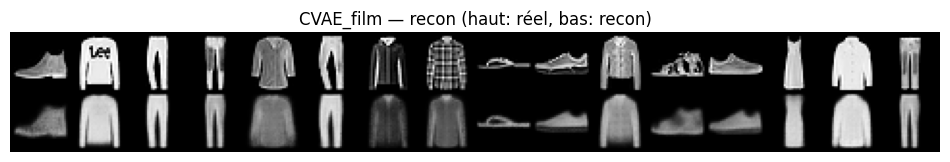

[CVAE_film] gen: fmd=91.311 | cond_acc=0.898 | clf_conf=0.819


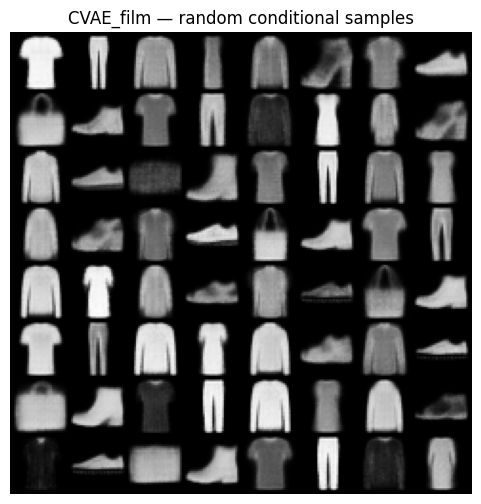

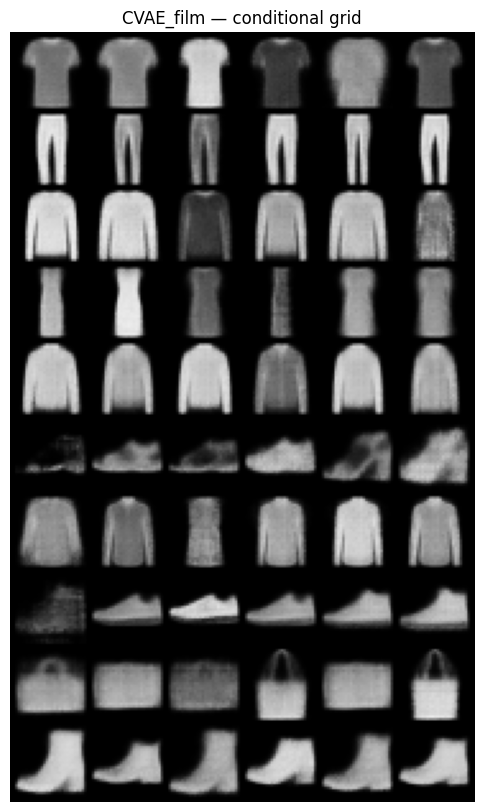

,arch_name,epochs,latent_dim,beta,bce_test,kl_test,active_units,fmd,cond_acc,clf_conf
0,CVAE_concat_onehot,15,16,1.0,226.393263,10.662700,9.0,67.790604,0.7515,0.762681
1,CVAE_emb_multi_inject,15,16,1.0,230.513056,8.621006,7.0,56.508514,0.8675,0.816247
2,CVAE_film,15,16,1.0,248.157647,4.498288,2.0,91.310692,0.8975,0.818662


In [125]:
ARCH3_NAME = "CVAE_film"

model_cvae3 = CVAE_FiLM(
    latent_dim=cfg.latent_dim,
    n_classes=10,
    emb_dim=16
)

row3 = run_cvae_protocol(model_cvae3, ARCH3_NAME)
results_df.tail(10)


Voici **le même format** que tes sections précédentes, avec **les références en gras**.

---

# 14. Architecture 4 — CVAE (Conditional BatchNorm / CBN)

## 14.1 Pourquoi cette architecture ?

Au lieu de concaténer $y$ ou d’appliquer FiLM directement,
on utilise une **Batch Normalization conditionnelle**.

Une BatchNorm standard (sans affine) produit :

$$
\mathrm{BN}(h)
$$

La CBN ajoute des paramètres dépendants de la classe :

$$
\mathrm{CBN}(h,y)=\gamma(y)\odot \mathrm{BN}(h)+\beta(y)
$$

où $\gamma(y)$ et $\beta(y)$ sont générés à partir d’un embedding :

$$
e(y)=\mathrm{Embed}(y)
$$

La condition agit donc **au moment de la normalisation des features**, ce qui structure
fortement l’influence de $y$ dans tout le réseau.

Cela force le modèle à apprendre :

$$
q_\phi(z\mid x,y)
\qquad\text{et}\qquad
p_\theta(x\mid z,y)
$$

avec une injection conditionnelle **dans chaque bloc convolutionnel**.

---

## 14.2 Schéma — Encoder

```text
Entrée x : (1 x 28 x 28)
   |
   v
Conv1 1->32  k=3 s=2
   |
   v
BN -> CBN(y) -> ReLU      (32 x 14 x 14)
   |
   v
Conv2 32->64  k=3 s=2
   |
   v
BN -> CBN(y) -> ReLU      (64 x 7 x 7)
   |
   v
Conv3 64->128  k=3 s=2
   |
   v
BN -> CBN(y) -> ReLU      (128 x 4 x 4)
   |
   v
Flatten -> FC
   |
   +---------------+----------------+
   |               |
   v               v
fc_mu            fc_logvar
   |               |
   +-------+-------+
           |
           v
Reparameterization -> z
```

---

## Décodeur

```text
z : (latent_dim)
   |
   v
z + e(y)
   |
   v
FC -> reshape (128 x 4 x 4)
   |
   v
Deconv1 128->64
   |
   v
BN -> CBN(y) -> ReLU      (64 x 7 x 7)
   |
   v
Deconv2 64->32
   |
   v
BN -> CBN(y) -> ReLU      (32 x 14 x 14)
   |
   v
Deconv3 32->1
   |
   v
Logits (1 x 28 x 28)
```

---

**Références**

* **CVAE (cadre théorique)** — **Sohn, K., Yan, X., Lee, H. (NeurIPS 2015)**, *Learning Structured Output Representation using Deep Conditional Generative Models*

* **Conditional Batch Normalization** — **de Vries, H. et al. (NeurIPS 2017)**, *Modulating Early Visual Processing by Language*


In [126]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, n_classes: int, emb_dim: int, n_channels: int):
        super().__init__()
        self.bn = nn.BatchNorm2d(n_channels, affine=False)
        self.embed = nn.Embedding(n_classes, emb_dim)
        self.to_gamma_beta = nn.Linear(emb_dim, 2 * n_channels)

        # init : gamma ≈ 1, beta ≈ 0 (stabilise)
        nn.init.zeros_(self.to_gamma_beta.weight)
        nn.init.zeros_(self.to_gamma_beta.bias)
        with torch.no_grad():
            self.to_gamma_beta.bias[:n_channels].fill_(1.0)  # gamma

    def forward(self, h: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # h: (B,C,H,W)
        h_norm = self.bn(h)
        ey = self.embed(y.long())
        gb = self.to_gamma_beta(ey)  # (B,2C)
        C = h.size(1)
        gamma, beta = gb[:, :C], gb[:, C:]

        gamma = gamma.unsqueeze(-1).unsqueeze(-1)  # (B,C,1,1)
        beta  = beta.unsqueeze(-1).unsqueeze(-1)
        return gamma * h_norm + beta


In [127]:
from typing import Tuple

class CVAE_CBN(nn.Module):
    def __init__(self, latent_dim: int = 16, n_classes: int = 10, emb_dim: int = 16):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.emb_dim = emb_dim

        # ----- Encoder
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)   # 14x14
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 7x7
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 4x4

        self.cbn1 = ConditionalBatchNorm2d(n_classes, emb_dim, 32)
        self.cbn2 = ConditionalBatchNorm2d(n_classes, emb_dim, 64)
        self.cbn3 = ConditionalBatchNorm2d(n_classes, emb_dim, 128)

        self.enc_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # ----- Decoder input embedding
        self.embed_dec = nn.Embedding(n_classes, emb_dim)

        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim + emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 4 * 4),
            nn.ReLU(),
        )

        # ----- Decoder deconvs
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0) # 4->7
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # 7->14
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)   # 14->28

        self.cbn4 = ConditionalBatchNorm2d(n_classes, emb_dim, 64)
        self.cbn5 = ConditionalBatchNorm2d(n_classes, emb_dim, 32)

    def encode(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.conv1(x)
        h = F.relu(self.cbn1(h, y))

        h = self.conv2(h)
        h = F.relu(self.cbn2(h, y))

        h = self.conv3(h)
        h = F.relu(self.cbn3(h, y))

        h = self.enc_fc(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        ey = self.embed_dec(y.long())
        h = self.dec_fc(torch.cat([z, ey], dim=1))
        h = h.view(-1, 128, 4, 4)

        h = self.deconv1(h)
        h = F.relu(self.cbn4(h, y))

        h = self.deconv2(h)
        h = F.relu(self.cbn5(h, y))

        logits = self.deconv3(h)  # logits
        return logits

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x, y)
        z = reparameterize(mu, logvar)
        logits = self.decode(z, y)
        return logits, mu, logvar

    @torch.no_grad()
    def sample(self, y: torch.Tensor, device: torch.device) -> torch.Tensor:
        self.eval()
        y = y.to(device)
        z = torch.randn(y.size(0), self.latent_dim, device=device)
        return self.decode(z, y)


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 01/15 | train: loss=266.944 bce=257.643 kl=9.300 | val: loss=247.079 bce=236.788 kl=10.290


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 02/15 | train: loss=243.045 bce=232.402 kl=10.643 | val: loss=242.247 bce=231.147 kl=11.101


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 03/15 | train: loss=239.404 bce=228.333 kl=11.071 | val: loss=239.726 bce=228.630 kl=11.096


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 04/15 | train: loss=237.624 bce=226.335 kl=11.289 | val: loss=237.534 bce=225.899 kl=11.635


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 05/15 | train: loss=236.661 bce=225.266 kl=11.395 | val: loss=237.356 bce=225.418 kl=11.938


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 06/15 | train: loss=235.904 bce=224.393 kl=11.511 | val: loss=236.130 bce=224.064 kl=12.066


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 07/15 | train: loss=235.192 bce=223.618 kl=11.574 | val: loss=235.780 bce=224.105 kl=11.675


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 08/15 | train: loss=234.827 bce=223.207 kl=11.620 | val: loss=235.124 bce=222.982 kl=12.141


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 09/15 | train: loss=234.255 bce=222.566 kl=11.689 | val: loss=235.322 bce=223.558 kl=11.764


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 10/15 | train: loss=234.164 bce=222.441 kl=11.723 | val: loss=235.351 bce=224.013 kl=11.338


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 11/15 | train: loss=233.812 bce=222.089 kl=11.723 | val: loss=234.816 bce=223.098 kl=11.718


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 12/15 | train: loss=233.553 bce=221.778 kl=11.775 | val: loss=234.318 bce=222.533 kl=11.785


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 13/15 | train: loss=233.366 bce=221.571 kl=11.795 | val: loss=234.355 bce=222.528 kl=11.827


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 14/15 | train: loss=233.104 bce=221.280 kl=11.824 | val: loss=234.553 bce=222.579 kl=11.974


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_cbn] ep 15/15 | train: loss=232.847 bce=220.984 kl=11.863 | val: loss=234.146 bce=222.079 kl=12.068
[CVAE_cbn] best val=234.1465 | saved: runs_vae_cvae/checkpoints/CVAE_cbn_best.pt


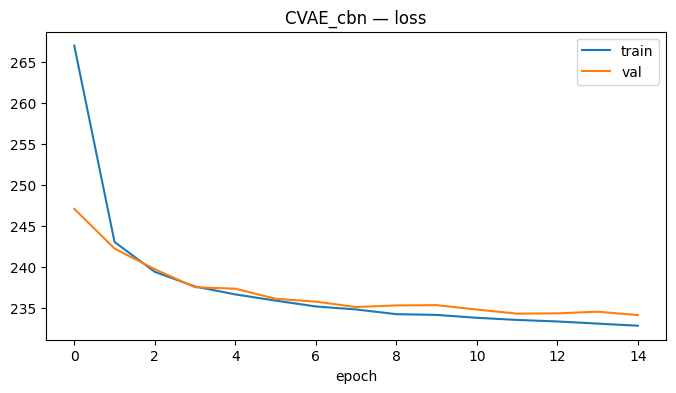

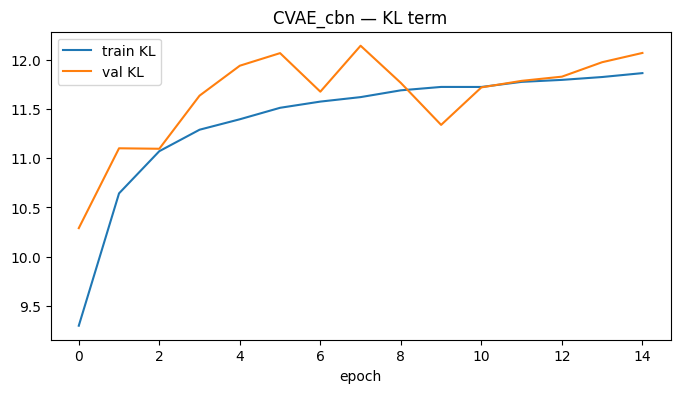

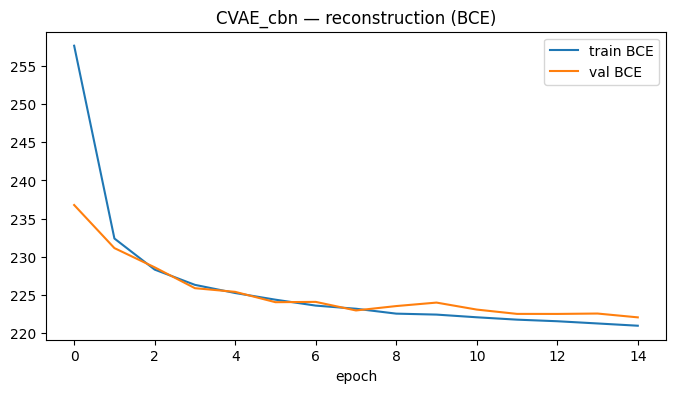

eval:   0%|          | 0/79 [00:00<?, ?it/s]

[CVAE_cbn] test: {'loss': 235.24453029785155, 'bce': 223.29552353515626, 'kl': 11.949007110595703, 'active_units': 9.0}


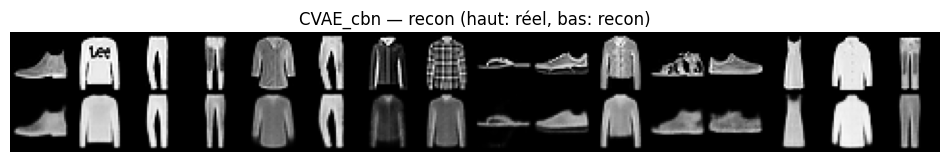

[CVAE_cbn] gen: fmd=42.097 | cond_acc=0.858 | clf_conf=0.836


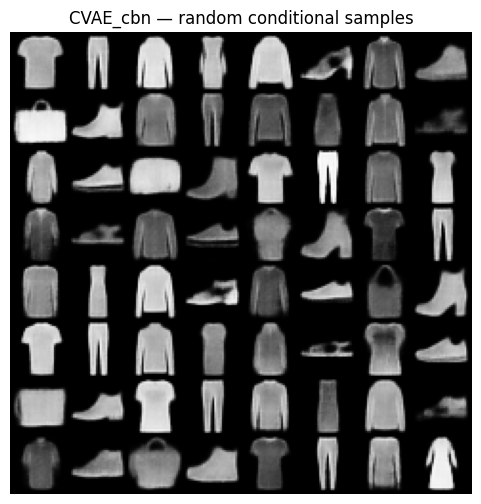

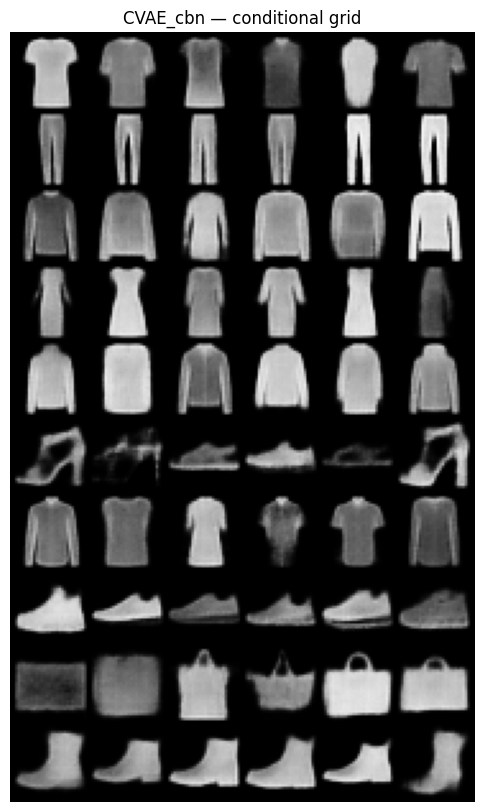

,arch_name,epochs,latent_dim,beta,bce_test,kl_test,active_units,fmd,cond_acc,clf_conf
0,CVAE_concat_onehot,15,16,1.0,226.393263,10.662700,9.0,67.790604,0.7515,0.762681
1,CVAE_emb_multi_inject,15,16,1.0,230.513056,8.621006,7.0,56.508514,0.8675,0.816247
2,CVAE_film,15,16,1.0,248.157647,4.498288,2.0,91.310692,0.8975,0.818662
3,CVAE_cbn,15,16,1.0,223.295524,11.949007,9.0,42.096794,0.8580,0.835621


In [128]:
ARCH4_NAME = "CVAE_cbn"

model_cvae4 = CVAE_CBN(
    latent_dim=cfg.latent_dim,
    n_classes=10,
    emb_dim=16
)

row4 = run_cvae_protocol(model_cvae4, ARCH4_NAME)
results_df.tail(10)


Voici la section au **même format** que les précédentes, avec **les bonnes références en gras** (et pas celle du *projection discriminator* qui concerne les GANs, pas les CVAE).

---

# 15. Architecture 5 — CVAE (Residual Blocks + Conditional BatchNorm)

## 15.1 Pourquoi cette architecture ?

On remplace la simple pile Conv/Deconv par des **blocs résiduels** (*ResBlocks*),
et on conditionne chaque bloc via une **Conditional BatchNorm (CBN)**.

Un bloc résiduel apprend :

$$
h_{\text{out}} = h_{\text{in}} + F(h_{\text{in}}, y)
$$

Ce type de bloc permet :

* une meilleure stabilité d’entraînement,
* des transformations plus riches,
* une meilleure qualité de reconstruction et de génération.

La condition $y$ agit **à l’intérieur même des blocs résiduels** via la CBN.

Cela force le modèle à apprendre :

$$
q_\phi(z\mid x,y)
\qquad\text{et}\qquad
p_\theta(x\mid z,y)
$$

avec une injection conditionnelle profonde et structurée.

---

## 15.2 Schéma — Encoder

```text
Entrée x : (1 x 28 x 28)
   |
   v
Conv stem -> (32 x 28 x 28)
   |
   v
ResBlock + CBN (32) -> Downsample -> (32 x 14 x 14)
   |
   v
ResBlock + CBN (64) -> Downsample -> (64 x 7 x 7)
   |
   v
ResBlock + CBN (128) -> (128 x 7 x 7)
   |
   v
GlobalAvgPool
   |
   +---------------+----------------+
   |               |
   v               v
fc_mu            fc_logvar
   |               |
   +-------+-------+
           |
           v
Reparameterization -> z
```

---

## Décodeur

```text
z + e(y)
   |
   v
FC -> (128 x 7 x 7)
   |
   v
ResBlock + CBN (128)
   |
   v
Upsample -> ResBlock + CBN (64) -> (64 x 14 x 14)
   |
   v
Upsample -> ResBlock + CBN (32) -> (32 x 28 x 28)
   |
   v
Conv out
   |
   v
Logits (1 x 28 x 28)
```

---

**Références**

* **CVAE (cadre théorique)** — **Sohn, K., Yan, X., Lee, H. (NeurIPS 2015)**, *Learning Structured Output Representation using Deep Conditional Generative Models*

* **Residual Networks** — **He, K. et al. (CVPR 2016)**, *Deep Residual Learning for Image Recognition*

* **Conditional Batch Normalization** — **de Vries, H. et al. (NeurIPS 2017)**, *Modulating Early Visual Processing by Language*


In [129]:
class ResBlockCBN(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, n_classes: int, emb_dim: int,
                 downsample: bool = False, upsample: bool = False):
        super().__init__()
        assert not (downsample and upsample), "Choose either downsample or upsample or none."

        self.downsample = downsample
        self.upsample = upsample

        self.cbn1 = ConditionalBatchNorm2d(n_classes, emb_dim, in_ch)
        self.cbn2 = ConditionalBatchNorm2d(n_classes, emb_dim, out_ch)

        # conv1 (stride depends on downsample; if upsample we upsample before conv1)
        stride1 = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride1, padding=1)

        # conv2
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)

        # Skip projection if shape changes
        self.proj = None
        if in_ch != out_ch or downsample or upsample:
            stride_proj = 2 if downsample else 1
            self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride_proj, padding=0)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        h = x

        # optional upsample
        if self.upsample:
            h = F.interpolate(h, scale_factor=2, mode="nearest")
            x_skip = F.interpolate(x, scale_factor=2, mode="nearest")
        else:
            x_skip = x

        # pre-activation + conv1
        h = F.relu(self.cbn1(h, y))
        h = self.conv1(h)

        # pre-activation + conv2
        h = F.relu(self.cbn2(h, y))
        h = self.conv2(h)

        # skip path
        if self.proj is not None:
            x_skip = self.proj(x_skip)

        return h + x_skip


In [130]:
from typing import Tuple

class CVAE_ResCBN(nn.Module):
    def __init__(self, latent_dim: int = 16, n_classes: int = 10, emb_dim: int = 16):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.emb_dim = emb_dim

        # ----- Encoder stem
        self.stem = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 28x28

        # Encoder ResBlocks
        self.enc_b1 = ResBlockCBN(32, 32, n_classes, emb_dim, downsample=True)   # 28->14
        self.enc_b2 = ResBlockCBN(32, 64, n_classes, emb_dim, downsample=True)   # 14->7
        self.enc_b3 = ResBlockCBN(64, 128, n_classes, emb_dim, downsample=False) # 7->7

        # Latent head
        self.enc_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.enc_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # ----- Decoder input
        self.embed_dec = nn.Embedding(n_classes, emb_dim)
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim + emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 7 * 7),
            nn.ReLU(),
        )

        # Decoder ResBlocks
        self.dec_b1 = ResBlockCBN(128, 128, n_classes, emb_dim, downsample=False, upsample=False) # 7->7
        self.dec_b2 = ResBlockCBN(128, 64, n_classes, emb_dim, upsample=True)  # 7->14
        self.dec_b3 = ResBlockCBN(64, 32, n_classes, emb_dim, upsample=True)   # 14->28

        # Output conv -> logits
        self.out_conv = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def encode(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.stem(x)                 # (32,28,28)
        h = self.enc_b1(h, y)            # (32,14,14)
        h = self.enc_b2(h, y)            # (64,7,7)
        h = self.enc_b3(h, y)            # (128,7,7)

        h = self.enc_pool(h)             # (128,1,1)
        h = self.enc_fc(h)               # (256)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        ey = self.embed_dec(y.long())
        h = self.dec_fc(torch.cat([z, ey], dim=1))
        h = h.view(-1, 128, 7, 7)

        h = self.dec_b1(h, y)            # (128,7,7)
        h = self.dec_b2(h, y)            # (64,14,14)
        h = self.dec_b3(h, y)            # (32,28,28)

        logits = self.out_conv(h)        # (1,28,28)
        return logits

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x, y)
        z = reparameterize(mu, logvar)
        logits = self.decode(z, y)
        return logits, mu, logvar

    @torch.no_grad()
    def sample(self, y: torch.Tensor, device: torch.device) -> torch.Tensor:
        self.eval()
        y = y.to(device)
        z = torch.randn(y.size(0), self.latent_dim, device=device)
        return self.decode(z, y)


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 01/15 | train: loss=268.840 bce=263.419 kl=5.421 | val: loss=256.823 bce=250.443 kl=6.380


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 02/15 | train: loss=252.113 bce=246.046 kl=6.068 | val: loss=252.160 bce=246.220 kl=5.940


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 03/15 | train: loss=249.001 bce=242.979 kl=6.023 | val: loss=252.807 bce=246.608 kl=6.199


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 04/15 | train: loss=247.265 bce=240.981 kl=6.284 | val: loss=246.467 bce=239.549 kl=6.919


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 05/15 | train: loss=245.327 bce=238.417 kl=6.910 | val: loss=245.352 bce=238.421 kl=6.931


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 06/15 | train: loss=243.298 bce=236.038 kl=7.260 | val: loss=243.265 bce=235.409 kl=7.856


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 07/15 | train: loss=242.160 bce=234.748 kl=7.413 | val: loss=243.617 bce=236.067 kl=7.550


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 08/15 | train: loss=241.481 bce=234.013 kl=7.468 | val: loss=241.333 bce=233.594 kl=7.739


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 09/15 | train: loss=240.919 bce=233.363 kl=7.555 | val: loss=241.989 bce=234.179 kl=7.810


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 10/15 | train: loss=240.428 bce=232.828 kl=7.600 | val: loss=240.758 bce=233.529 kl=7.230


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 11/15 | train: loss=240.080 bce=232.438 kl=7.642 | val: loss=241.760 bce=233.809 kl=7.951


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 12/15 | train: loss=239.807 bce=232.147 kl=7.660 | val: loss=242.690 bce=234.536 kl=8.154


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 13/15 | train: loss=239.488 bce=231.790 kl=7.697 | val: loss=241.656 bce=233.985 kl=7.671


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 14/15 | train: loss=239.325 bce=231.609 kl=7.716 | val: loss=239.826 bce=231.903 kl=7.923


train:   0%|          | 0/430 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

[CVAE_res_cbn] ep 15/15 | train: loss=239.057 bce=231.333 kl=7.724 | val: loss=240.996 bce=233.062 kl=7.934
[CVAE_res_cbn] best val=239.8260 | saved: runs_vae_cvae/checkpoints/CVAE_res_cbn_best.pt


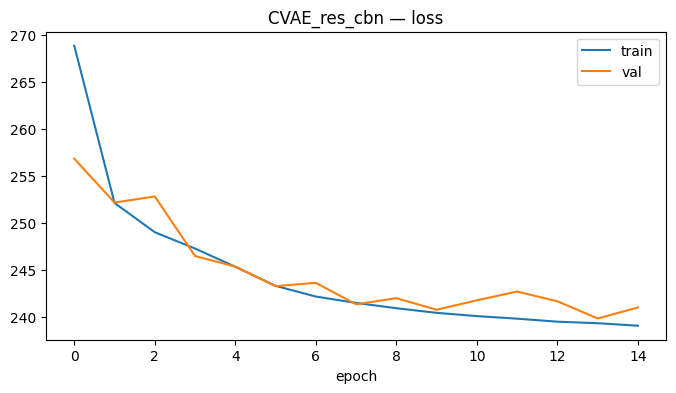

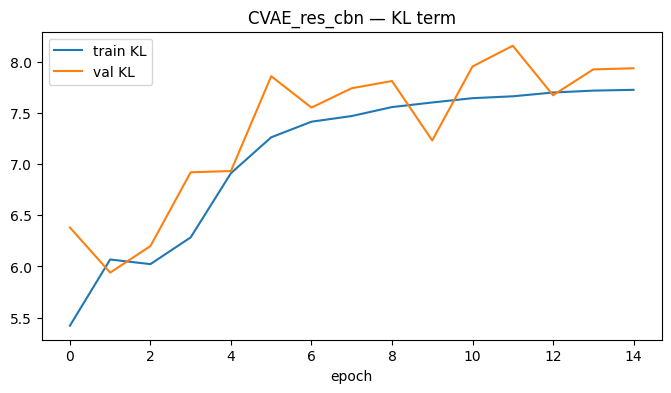

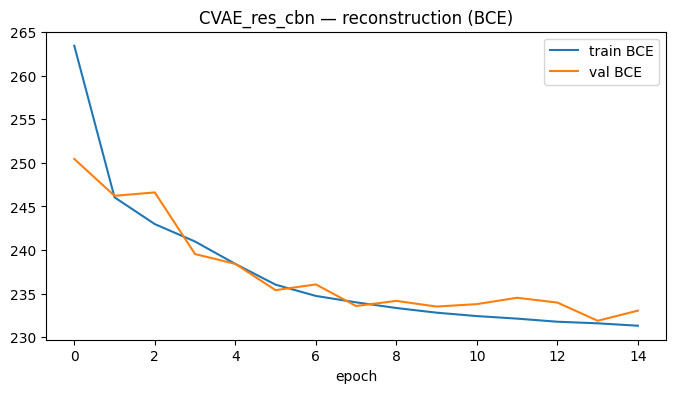

eval:   0%|          | 0/79 [00:00<?, ?it/s]

[CVAE_res_cbn] test: {'loss': 240.84506599121093, 'bce': 232.96965947265625, 'kl': 7.875406533813477, 'active_units': 4.0}


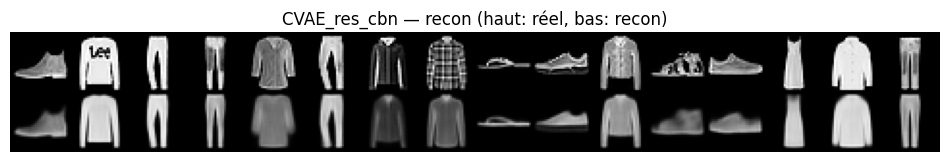

[CVAE_res_cbn] gen: fmd=60.355 | cond_acc=0.886 | clf_conf=0.825


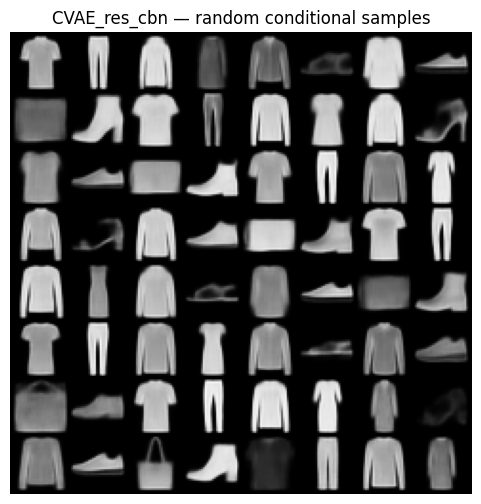

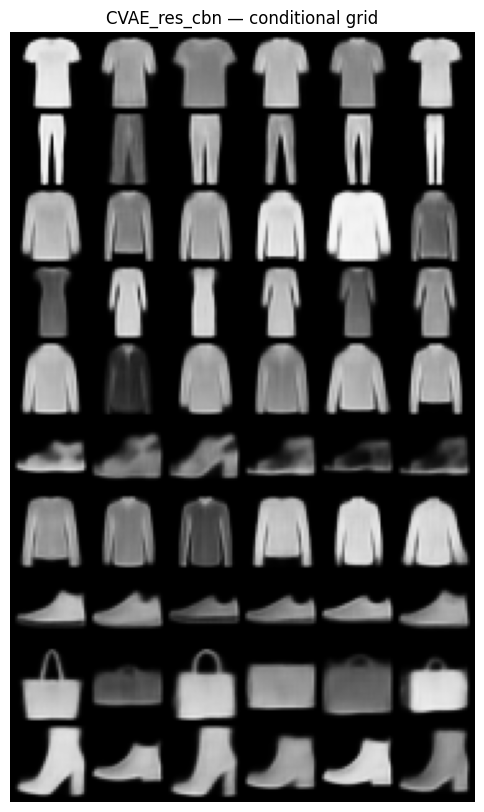

,arch_name,epochs,latent_dim,beta,bce_test,kl_test,active_units,fmd,cond_acc,clf_conf
0,CVAE_concat_onehot,15,16,1.0,226.393263,10.662700,9.0,67.790604,0.7515,0.762681
1,CVAE_emb_multi_inject,15,16,1.0,230.513056,8.621006,7.0,56.508514,0.8675,0.816247
2,CVAE_film,15,16,1.0,248.157647,4.498288,2.0,91.310692,0.8975,0.818662
3,CVAE_cbn,15,16,1.0,223.295524,11.949007,9.0,42.096794,0.8580,0.835621
4,CVAE_res_cbn,15,16,1.0,232.969659,7.875407,4.0,60.354561,0.8855,0.824688


In [131]:
ARCH5_NAME = "CVAE_res_cbn"

model_cvae5 = CVAE_ResCBN(
    latent_dim=cfg.latent_dim,
    n_classes=10,
    emb_dim=16
)

row5 = run_cvae_protocol(model_cvae5, ARCH5_NAME)
results_df.tail(15)


Voici une réécriture de votre analyse comparative, adoptant un ton scientifique et rigoureux, conforme aux standards académiques tout en conservant l'essence de vos découvertes.

---

# 17. Analyse comparative des architectures CVAE

L'étude des performances met en évidence des disparités significatives selon la méthode d'intégration de la variable de classe  au sein du réseau. L'analyse démontre que la stratégie de conditionnement impacte directement trois dimensions critiques : la fidélité de reconstruction, l'exploitation de l'espace latent et la qualité intrinsèque des échantillons générés.

## 17.1 Évaluation par architecture

#### **CVAE_cbn : L'équilibre optimal**

Le modèle s'impose comme la solution la plus performante sur l'ensemble des métriques :

* **Fidélité de reconstruction** : Obtient le score le plus bas (`bce_test = 223.30`).
* **Qualité générative** : Présente le meilleur score FMD (`42.10`).
* **Cohérence sémantique** : Maintient une précision conditionnelle élevée (`cond_acc = 0.858`).
* **Richesse latente** : Exploite efficacement 9 dimensions sur 16 (`active_units`).

L'utilisation de la **BatchNorm conditionnelle** permet de moduler les statistiques internes du réseau sans saturer les informations provenant de l'espace latent.

#### **CVAE_emb_multi_inject : Une alternative robuste**

L'injection répétée d'un embedding s'avère supérieure à l'approche *one-hot* classique :

* **Génération** : `fmd = 56.51`.
* **Cohérence** : `cond_acc = 0.8675`.
* **Latent** : Utilisation modérée (`active_units = 7/16`).

#### **CVAE_film : L'hyper-conditionnement**

Cette architecture affiche des résultats contrastés, illustrant un phénomène de domination de la condition sur le latent :

* **Reconstruction et Génération** : Affiche les performances les plus faibles (`bce_test = 248.16`, `fmd = 91.31`).
* **Précision sémantique** : Atteint le score maximal (`cond_acc = 0.8975`).
* **Atrophie latente** : Seules 2 dimensions sur 16 restent actives.

La puissance des paramètres  et  semble capturer l'intégralité de l'information de classe au détriment de l'encodeur. Une augmentation du paramètre  au-delà de  pourrait être nécessaire pour contraindre le modèle à exploiter davantage le vecteur .

#### **CVAE_concat_onehot : Référence de base**

L'approche par concaténation simple souffre de la parcimonie du vecteur *one-hot* :

* **Reconstruction** : Satisfaisante (`234.92`).
* **Cohérence** : Limitée (`cond_acc = 0.7515`).
* **Latent** : Forte sollicitation (`9/16 unités actives`) pour compenser la faiblesse du conditionnement.

#### **CVAE_res_cbn : Impact des connexions résiduelles**

L'introduction de blocs résiduels favorise la cohérence (`cond_acc = 0.8855`) mais semble désengager partiellement l'espace latent (`active_units = 4/16`), les *skip connections* offrant potentiellement des chemins de gradient contournant l'encodage strict dans .

---

## 17.2 Synthèse des enseignements

### Arbitrage entre force du conditionnement et usage du latent

Un compromis apparaît nettement : l'injection massive de la condition  tend à marginaliser le rôle du vecteur latent .

| Architecture | Précision (cond_acc) | Unités Actives | Observation |
| --- | --- | --- | --- |
| **CVAE_film** | 0.898 | 2/16 | Domination de la condition |
| **CVAE_res_cbn** | 0.886 | 4/16 | Latent sous-exploité |
| **CVAE_cbn** | 0.858 | 9/16 | **Équilibre optimal** |
| **CVAE_emb_multi** | 0.868 | 7/16 | Compromis stable |
| **CVAE_concat** | 0.752 | 9/16 | Conditionnement insuffisant |

### Avantages de la normalisation conditionnelle

Les méthodes fondées sur la modulation des statistiques (CBN) présentent les meilleurs indices de réalisme (FMD). La séparation entre la normalisation (agnostique à la classe) et la modulation (spécifique à la classe) assure une injection "propre" de l'information sémantique, contrairement au mélange de *features* opéré par la concaténation.

---
## 17.3 Limites de l'étude et perspectives

Les résultats obtenus doivent être interprétés en tenant compte de trois limites méthodologiques, présentées par ordre d'impact potentiel sur les conclusions.

### Limites identifiées

**1. Absence de répétitions statistiques**

Toutes les expériences ont été réalisées avec une unique graine aléatoire (*seed*), ce qui empêche l'estimation d'intervalles de confiance. Bien que les tendances observées entre architectures apparaissent cohérentes, une partie des écarts pourrait provenir de fluctuations liées à l'initialisation plutôt que de différences structurelles robustes. Cette limitation affecte principalement la généralisation quantitative des résultats, tandis que les comparaisons qualitatives entre mécanismes de conditionnement demeurent valides.

**2. Paramètre β uniforme pour toutes les architectures**

Le coefficient de régularisation a été fixé à β = 1 afin de garantir un protocole strictement comparable. Ce choix méthodologique peut néanmoins désavantager certaines architectures, notamment celles où le conditionnement est particulièrement puissant (comme FiLM). Pour ces modèles, une pression KL plus élevée pourrait s'avérer nécessaire pour éviter une sous-utilisation du latent et maximiser leur potentiel génératif. L'utilisation d'un β unique limite donc l'exploration du plein potentiel de chaque architecture.



### Perspectives de recherche

Plusieurs prolongements permettraient de consolider et d'étendre ces travaux :

**Robustesse statistique**
- Répéter les expériences sur 5 à 10 graines différentes pour obtenir des moyennes et écarts-types statistiquement significatifs

**Optimisation spécifique par architecture**
- Adapter le coefficient β individuellement pour chaque modèle 

**Analyse dimensionnelle**
- Étudier l'influence de la dimension latente (8, 16, 32, 64) sur l'usage effectif du latent et la qualité de génération
- Identifier les seuils critiques où certaines architectures basculent vers le *posterior collapse*



---

## Conclusion

L'architecture **CVAE_cbn** s'établit comme la référence pour ce projet. Elle réalise une synthèse efficace entre la fidélité de reconstruction, l'organisation de l'espace latent et la qualité générative. L'étude souligne une loi de proportionnalité inverse entre la force d'injection de la condition et l'utilité du latent, illustrée de manière extrême par le modèle FiLM.
